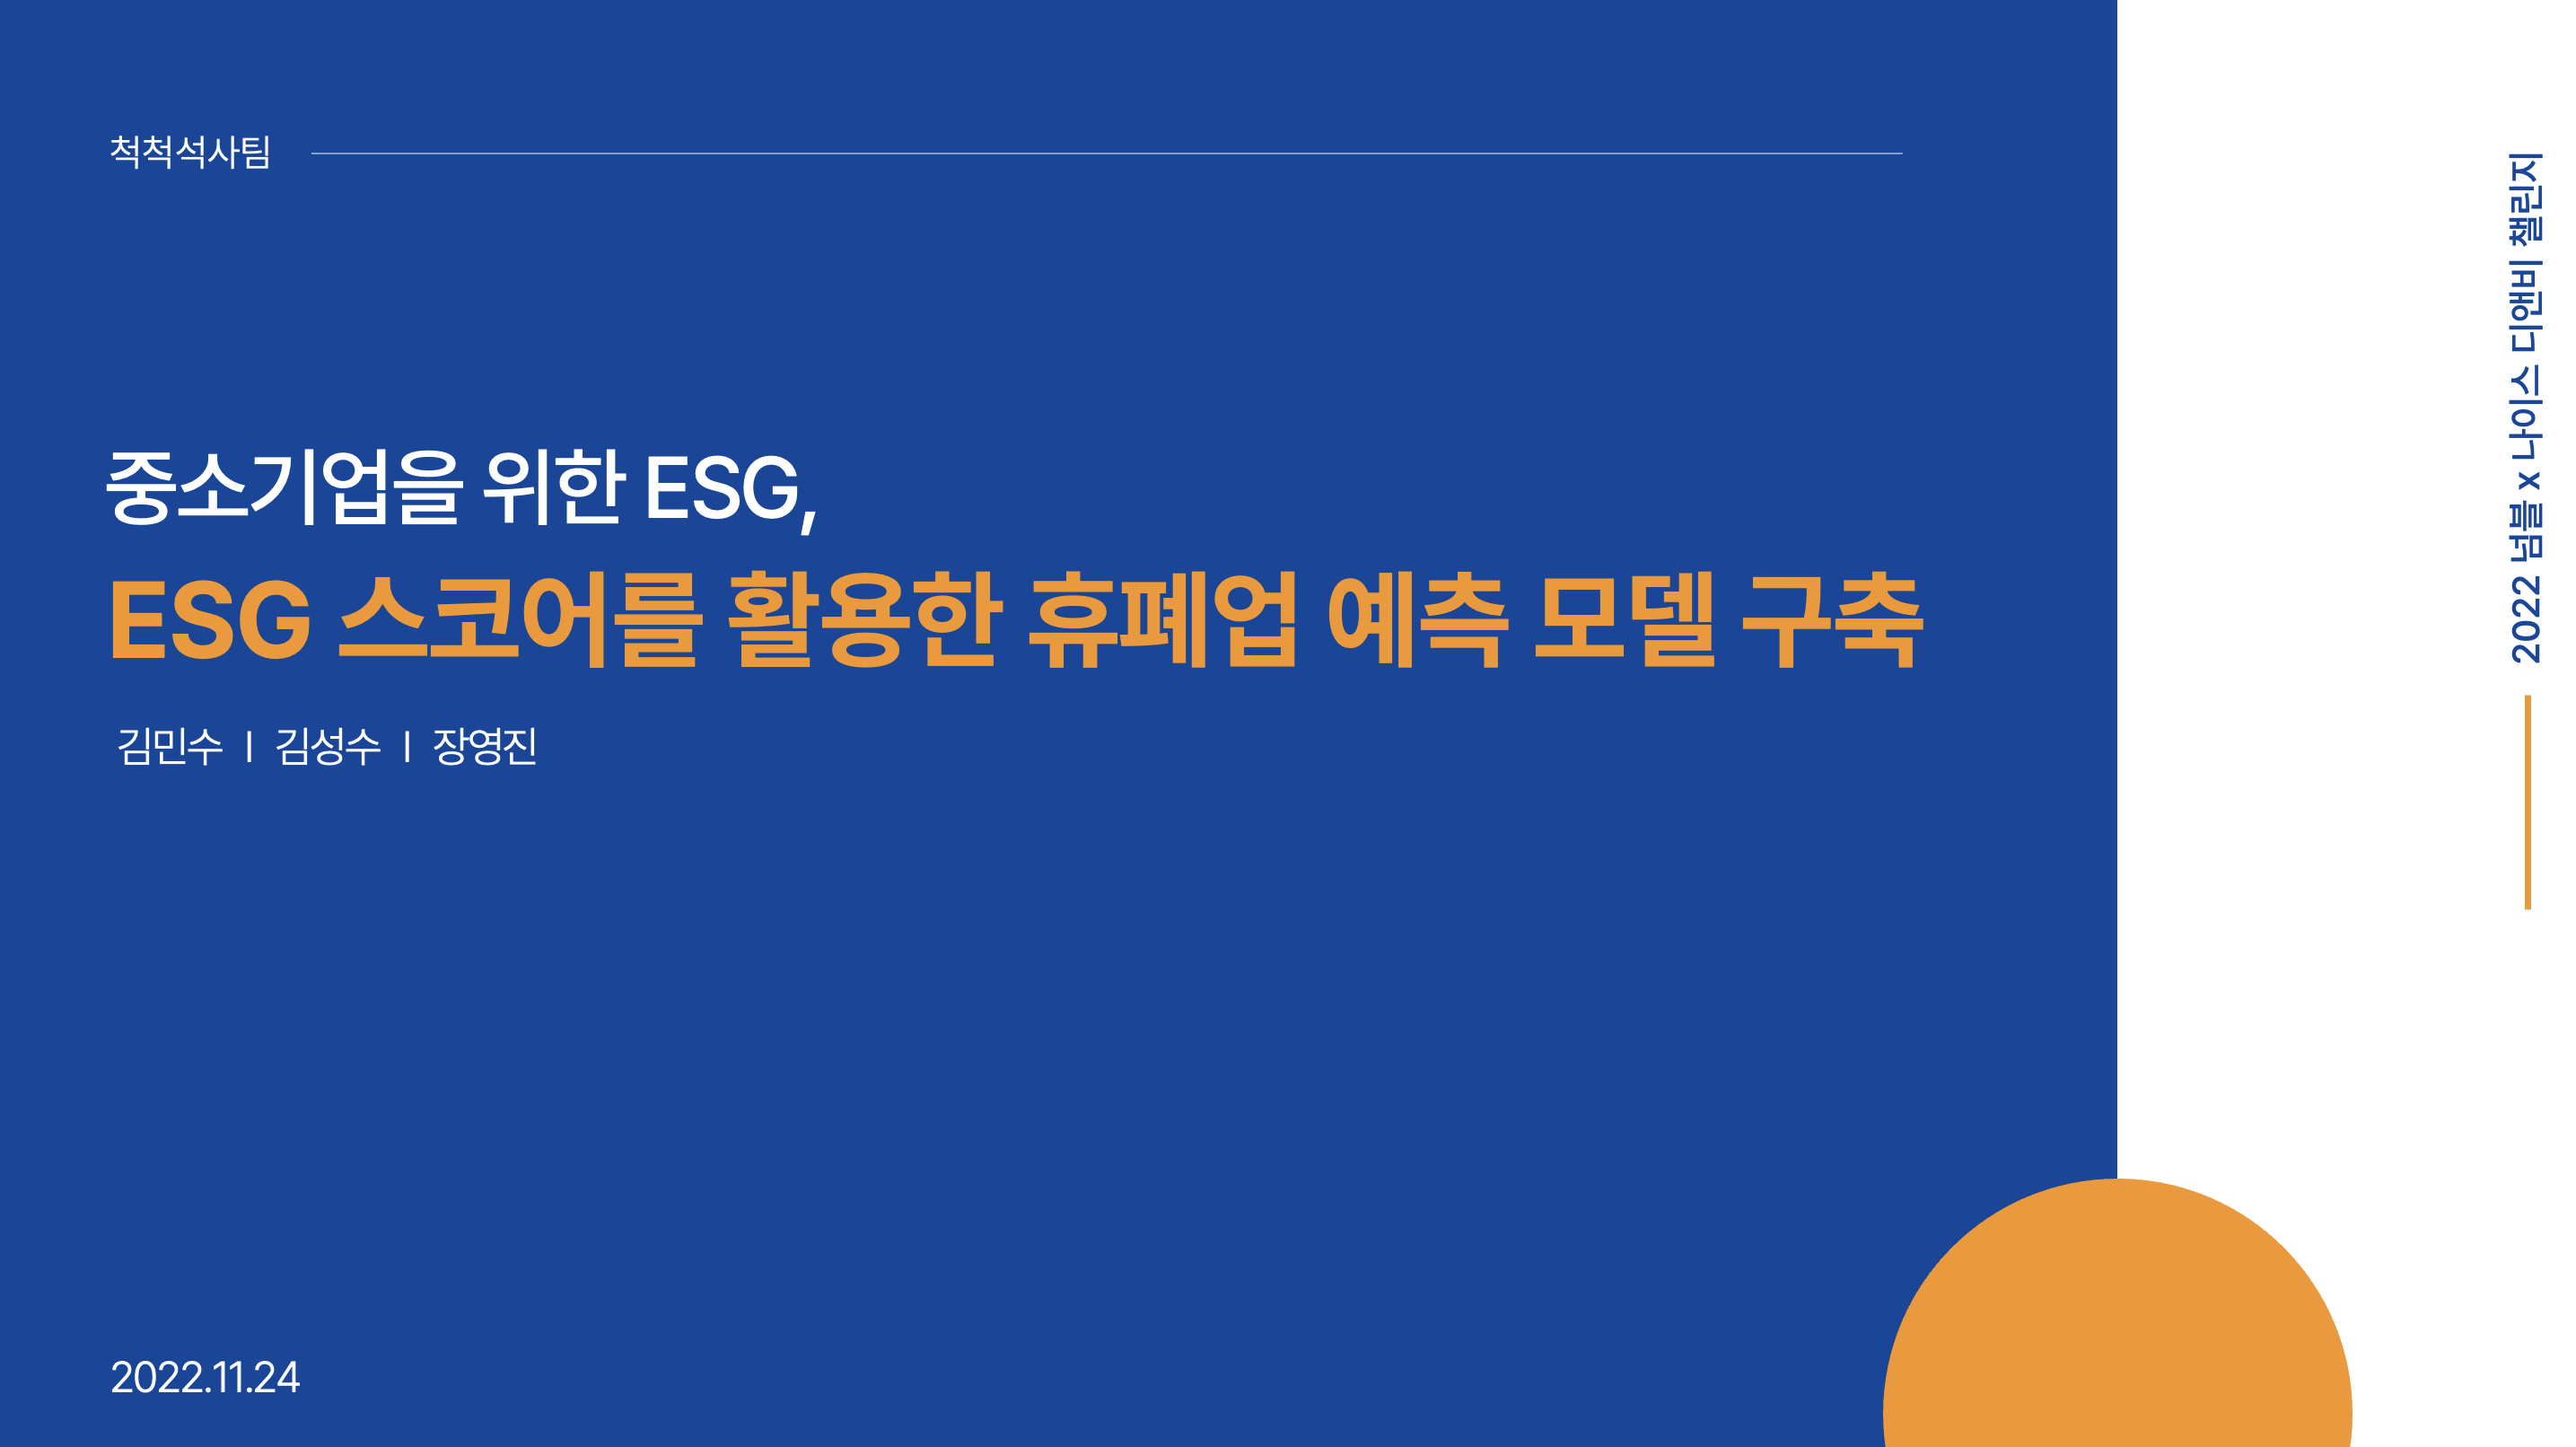

# 데이터 가공 및 분석

## 가. 기초 환경 설정

### 패키지 및 라이브러리

In [ ]:
!pip install tabulate

!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy

In [ ]:
#형태소 분석기(konlpy)의 말뭉치 mecab 설치
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc
import scipy  
import seaborn as sns
from tqdm import notebook
import json
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import copy
from tabulate import tabulate
from konlpy.tag import Mecab
mecab = Mecab()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

## 나. 데이터 수집

### 0) 분석 프레임워크

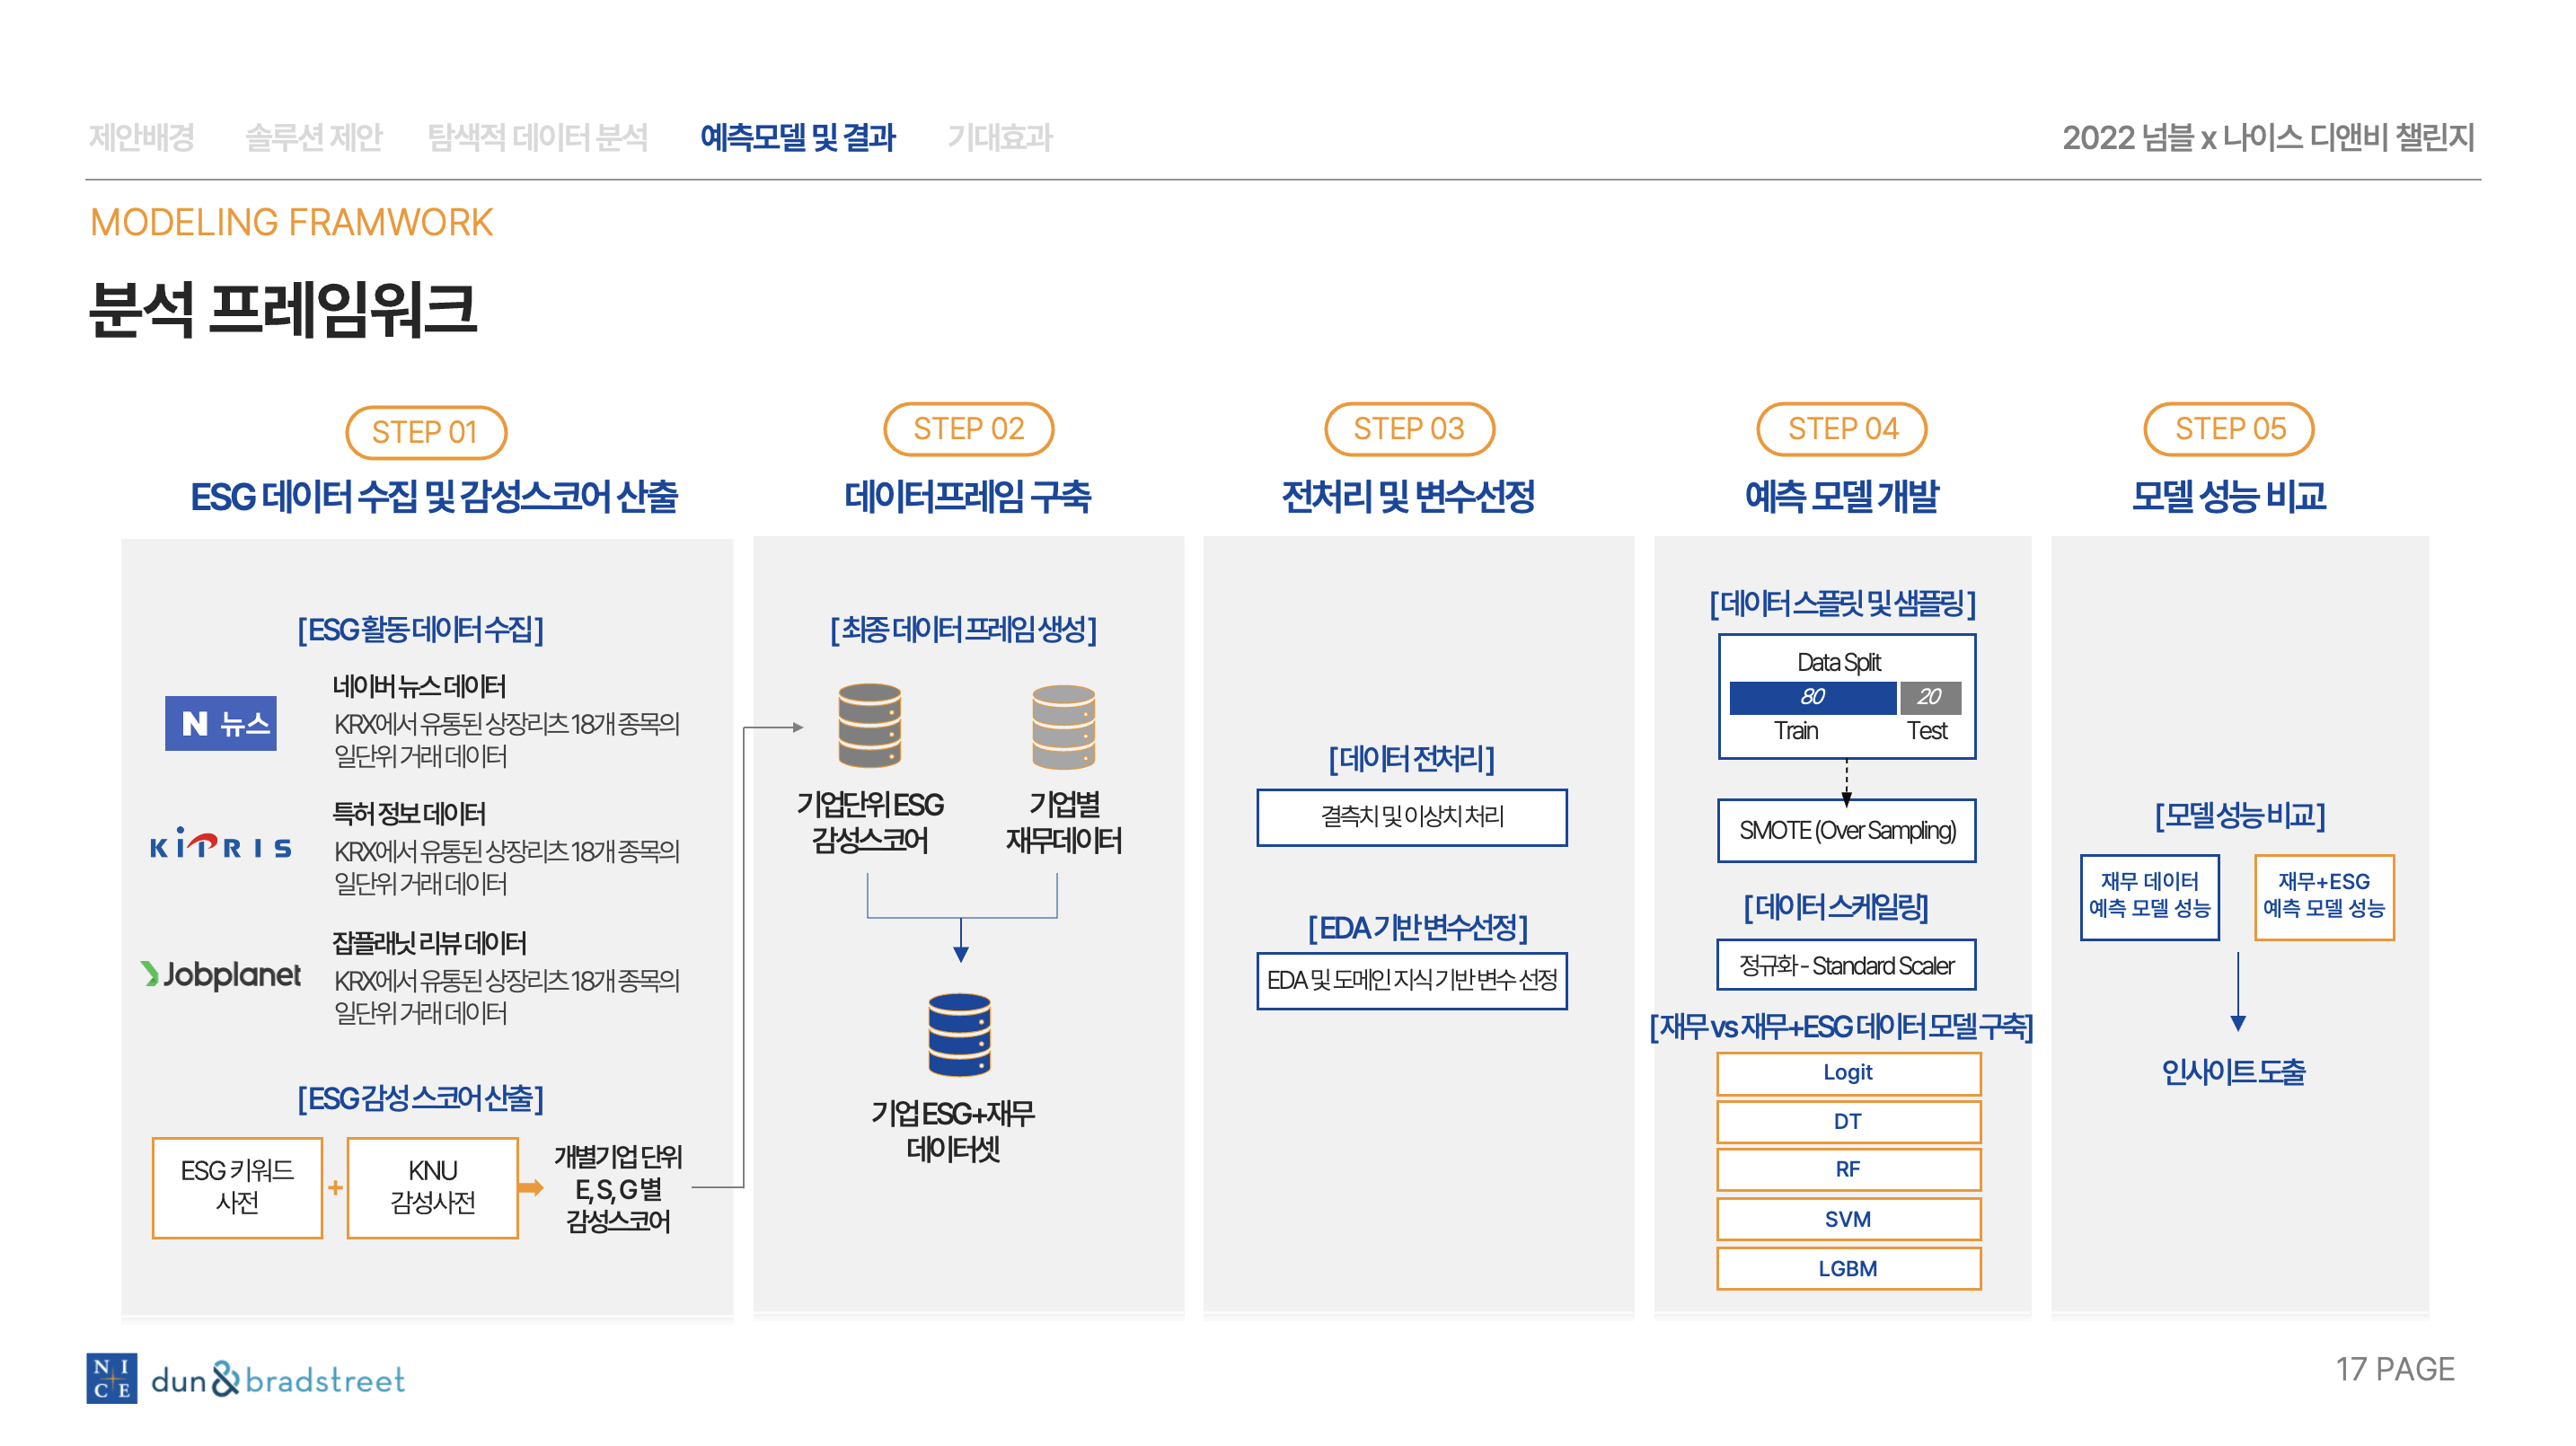

### 1) 중소기업 휴폐업 데이터
[데이터 목록 ] 

나이스 DNB 제공 데이터

- 액티브 중소법인 재무보유
- 휴폐업 중소법인 재무보유
- 재무데이터

In [3]:
#액티브 중소법인 재무보유 데이터 
actv = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/액티브 중소법인 재무보유.xlsx', sheet_name=0)
#휴폐업 중소법인 재무보유 
clos = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/휴폐업 중소법인 재무보유.xlsx', sheet_name=0)
# 재무데이터 
finance = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/재무데이터.txt", sep = "\t", engine='python', encoding = "cp949")


#데이터 결합 
actv['target'] = 0 #종속변수 생성 
clos['target'] = 1
actv.rename(columns = {'CMP_NM1':'CMP_NM'}, inplace=True )
df_concat = pd.concat([actv,clos], axis = 0)

#PFIX_NM,SFIX_NM 결합
df_concat['result1'] = df_concat['CMP_PFIX_NM'] + "" + df_concat['CMP_NM']
df_concat['result2'] = df_concat['CMP_NM'] + "" + df_concat['CMP_SFIX_NM']
df_concat['result1'] = df_concat['result1'].fillna('')
df_concat['result2'] = df_concat['result2'].fillna('')
df_concat['result'] = df_concat['result1'] +""+ df_concat['result2']
df_concat['result'] = df_concat['result'].replace('',np.nan)
df_concat['result'] = df_concat['result'].fillna(df_concat['CMP_NM'] )
df_concat['CMP_NM_PFIX_SFIX'] = df_concat['result']
df_concat = df_concat.drop(['result1','result2','result'],axis=1)

print(tabulate(df_concat.head(), headers = 'keys', tablefmt = 'pretty'))
print(df_concat.shape)

+---+------------+-------------+--------------+-------------+---------------------------------+--------+---------+---------+-------------+------------+-----------------+---------+---------+-------------+---------+---------+---------+------------+---------------+-------------+------------+---------+-----------+--------------------------------+---------+---------------------+--------------------+---------+--------+------------------+
|   |   BIZ_NO   | CMP_PFIX_NM |    CMP_NM    | CMP_SFIX_NM |             CMP_ENM             | BZ_TYP | CMP_SCL | PBCO_GB | PSN_CORP_GB | HDOF_BR_GB | FR_IVST_CORP_YN | VENT_YN | LIST_CD | IND_CD_ORDR | IND_CD1 | IND_CD2 | IND_CD3 | PB_ORG_TYP | MDSCO_PRTC_YN | HDOF_CMP_CD | ESTB_DATE  | ESTB_GB | LIST_DATE |          MN_BIZ_CONT           | NATN_NM |    HOMEPAGE_URL     |       CEO_NM       | EMP_CNT | target | CMP_NM_PFIX_SFIX |
+---+------------+-------------+--------------+-------------+---------------------------------+--------+---------+---------+----

### 1) ESG 데이터 수집 및 감성 스코어 산출
[데이터 목록 및 출처]

아래 사이트에서 ESG 데이터 수집을 위한 데이터 크롤링

- 잡플래닛 
- 네이버 뉴스
- 특허정보시스템

In [ ]:
#수집해야 하는 기업 정보 저장
queries_CMP_NN = df_concat['CMP_NM'].tolist()
queries_CMP_NM_PFIX_SFIX = df_concat['CMP_NM_PFIX_SFIX'].tolist()
queries_BIZ_NO = df_concat['BIZ_NO'].tolist()

#### - 잡플래닛(Jobplanet) 데이터 

In [ ]:
#잡플래닛 수집 코드
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#잡플래닛 수집 코드
login_url = 'https://www.jobplanet.co.kr/users/sign_in'

#email 본인 아이디, password 본인 패스워드 입력 단, 리뷰를 남겨서 전체 접근이 가능한 상태여야함
#현재 크롤링 코드에서는 아이디 비밀번호 입력 제외
email = ''
password = ''


LOGIN_INFO ={
    'user[email]' : email,
    'user[password]' : password,
    'commit' : '로그인'
}

session = requests.session()

res = session.post(login_url, data = LOGIN_INFO, verify = False)

res.raise_for_status()
result = []


def clean_str(text):
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = text.replace('\r','. ')
    return text

def get_number(text):
  pattern =  "/([0-9]+)/"
  result = re.search(pattern, text)
  return result.group(1)

queries = queries_CMP_NM_PFIX_SFIX

for n,query in enumerate(queries):
  time.sleep(3)
  url = 'https://www.jobplanet.co.kr/search/companies/'+str(query)
  #urls 만들기
  #bs로 해당 서치에 query와 똑같은 text의 주소 저장 => urls로 보내기
  res = session.get(url)
  try:
    res.raise_for_status()
  except: continue
  soup = BeautifulSoup(res.text, 'html.parser')

  url_set = [i.a['href'] for i in soup.find_all('dt','us_titb_l3') if i.a.text in query]

  res_set =[]
  urls =[]

  for i in url_set:
    urls.append('https://www.jobplanet.co.kr/'+i)

  for i in urls:
    res_set.append(session.get(i).url)

  for j in res_set:
  #url 은 보고싶은 기업의 리뷰 URL 이며 마지막은 ?page= 형태로 해야함, last_page는 해당 기업 리뷰의 마지막 페이지 입력
    last_page = 6
    time.sleep(3)
    for idx in range(1,last_page):
        url = j+'?page='+str(idx)
        res = session.get(url)
        res.raise_for_status()

        soup = BeautifulSoup(res.text, 'html.parser')

        count3 = 0
        count4 = 0
        count5 = 0

        try:
            for z in range(5):
                reviewer_info = []
                # 응답자 정보
                position = soup.select('.content_top_ty2 > span.txt1')[0 + count4].text
                status = soup.select('.content_top_ty2 > span.txt1')[1 + count4].text
                loc = soup.select('.content_top_ty2 > span.txt1')[2 + count4].text

                day = soup.select('.content_top_ty2 > span.txt1')[3+ count4].text

                # 점
                star_rating = soup.select('.us_star_m > div.star_score')[0+k]['style'][6:-1]

                # rating 5*5
                promotion = soup.select('.bl_score')[0 + count5]['style'][6:-1]
                welfare = soup.select('.bl_score')[1 + count5]['style'][6:-1]
                balance = soup.select('.bl_score')[2 + count5]['style'][6:-1]
                culture = soup.select('.bl_score')[3 + count5]['style'][6:-1]
                top = soup.select('.bl_score')[4 + count5]['style'][6:-1]
                # 중심 제목
                content = soup.select('h2.us_label')[0+k].text
                # 장단점 경영진 의견
                merit = soup.select('dl.tc_list > dd.df1 > span')[0 + count3].text
                disadvantages = soup.select('dl.tc_list > dd.df1 > span')[1 + count3].text
                df_tit = soup.select('dl.tc_list > dd.df1 > span')[2 + count3].text


                reviewer_info = [position, status, loc, day, star_rating, promotion, welfare, balance, culture, top,clean_str(content),clean_str(merit),clean_str(disadvantages), clean_str(df_tit),get_number(url),query]

                result.append(reviewer_info)
                reviewer_info=[]
                count3 += 3
                count4 += 4
                count5 += 5
                # print("pass :"+str(idx)+"-"+str(k))
        except :
            print("fail :" + str(idx))
            pass

    colname = ['직무','상황','지역','작성일','총점','승진 기회 및 가능성','복지 및 급여','업무와 삶의 균형','사내문화','경영진','총평','장점','단점','바라는점','잡플래닛 company Id','회사명']
    df = pd.DataFrame(result,columns=colname)
    #200개의 회사 마다 checkpoint 생성
    if n%200==0:
      print("###################SAVE CHPT####################")
      df.to_excel("jp_actv_pre"+str(n)+".xlsx")

In [ ]:
jp_actv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/jp_actv_pre.csv')
jp_clos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/jp_cols_pre.csv')

In [ ]:
print(tabulate(jp_actv.head(), headers = 'keys', tablefmt = 'pretty'))
print("ESG_jp_actv Shape:'",jp_actv.shape)
print("ESG_jp_clos Shape:'",jp_clos.shape)

+---+------------+--------------+--------+--------+------+----------+------+---------------------+--------------+------------------+----------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+---------------------+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------

#### - ESG 뉴스 데이터 

In [ ]:
# 함수정의 - 네이버 뉴스api를 이용한 기업별 뉴스정보 수집

def crwaler(i) : 
    client_id = "Yrko9YKx5961TSQUmvXO"
    client_secret = "2oxOjGLgMY"
    
    search_word = i #검색어
    encode_type = 'json' 
    max_display = 100 #출력 뉴스 수
    sort = 'date' #결과값의 정렬기준 시간순 date, 관련도 순 sim
    start = 1 # 출력 위치

    url = f"https://openapi.naver.com/v1/search/news.{encode_type}?query={search_word}&display={str(int(max_display))}&start={str(int(start))}&sort={sort}"

    #헤더에 아이디와 키 정보 넣기
    headers = {'X-Naver-Client-Id' : client_id,
               'X-Naver-Client-Secret':client_secret
               }

    #HTTP요청 보내기
    r = requests.get(url, headers=headers)
    #요청 결과 보기 200 이면 정상적으로 요청 완료
    j = r.json()
    
    while (j['display']!= 0) :
        df = pd.DataFrame(j['items'])

        def clean_html(x):
          x = re.sub("\&\w*\;","",x)
          x = re.sub("<.*?>","",x)
          return x

        df['title'] = df['title'].apply(lambda x: clean_html(x))
        df['description'] = df['description'].apply(lambda x: clean_html(x))

        df.to_csv(f'news_search_result_{search_word}.csv')
        print(f'{search_word}기업 저장 완료')
        break
    else : 
        print(f'{search_word}기업 뉴스 없음')

In [ ]:
news_actv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/news_actv_pre.csv')
news_clos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/news_clos_pre.csv')

In [ ]:
#2018년 이후 뉴스 데이터만 필터링

news_actv = news_actv[news_actv['pubDate'].str.contains('2018|2019|2020|2021')]
news_actv = news_actv[~news_actv['pubDate'].str.contains('▲ 낙찰업체')]

news_clos = news_clos[news_clos['pubDate'].str.contains('2018|2019|2020|2021')]
news_clos = news_clos[~news_clos['pubDate'].str.contains('▲ 낙찰업체')]


print(tabulate(news_actv.head(), headers = 'keys', tablefmt = 'pretty'))
print("ESG_jp_actv Shape:'",news_actv.shape)
print("ESG_jp_clos Shape:'",news_clos.shape)

+---+------------+----------+-------------------+------------+---------------+--------+----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### - 특허 정보 데이터

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
import cloudscraper
import requests
from bs4 import BeautifulSoup
from collections import OrderedDict
from selenium.common.exceptions import NoSuchElementException        
from fake_useragent import UserAgent
import pandas as pd
import time
import random
import re
import json
from pandas import json_normalize
from datetime import datetime, timezone
import csv

actv = pd.read_excel(r'C:\Users\Yeong\Desktop\NICE공모전\data\액티브 중소법인 재무보유.xlsx', sheet_name=0)
clos = pd.read_excel(r'C:\Users\Yeong\Desktop\NICE공모전\data\휴폐업 중소법인 재무보유.xlsx', sheet_name=0)
# biz_list = actv['BIZ_NO'].values.tolist()


#%% 데이터 수집할 리스트 정의 
patent_list = []
error_list = [] 

#%% 

for i in range(0, len(actv)):
    if (i % 100 == 0) & (i % 1000 != 0): 
        print('\n','쉬는 중.....','\n')
        time.sleep(random.uniform(30,50))
         
    #액티브 기업 크롤링 
    biz_no = str(actv['BIZ_NO'].iloc[i])
    biz_name = actv['CMP_NM1'].iloc[i]]

    print('<----------------- Idx : {} / 사업자번호 : {}'.format(i, biz_no), '----------------->')
    
    try:
        browser = webdriver.Chrome('C:/Users/Yeong/Desktop/공부/python_code/chromedriver.exe')
        browser.maximize_window()
        url = 'http://kpat.kipris.or.kr/kpat/searchLogina.do?next=MainSearch'
        browser.get(url)
        time.sleep(random.uniform(2,3))
        element = browser.find_element_by_xpath('//*[@id="queryText"]')
        #element = browser.find_element_by_xpath('//*[@id="input-61"]')
        element.click()
        
        #biz_no_input = 'AP=[{}]'.format(biz_list[i])
        
        element.send_keys(biz_no)
        element.send_keys(Keys.ENTER)
        time.sleep(random.uniform(2,3))
        
        # 본문 내용이 있으면, 90개 보여주는 아이콘 누르기 
        if len(browser.find_elements_by_class_name('search_section_title')) > 0 : 
            icon_page = browser.find_element_by_xpath('//*[@id="opt28"]')
            icon_page.click()
            icon_show_90 = browser.find_element_by_xpath('//*[@id="opt28"]/option[3]')
            icon_show_90.click()
            icon_go = browser.find_element_by_xpath('//*[@id="pageSel"]/a/img')
            icon_go.click()
            time.sleep(random.uniform(1,2))
        
        #제목 
        srch_title = [i.text for i in browser.find_elements_by_class_name("search_section_title")]
        #요약내용
        srch_text = [i.text for i in browser.find_elements_by_class_name("search_txt")]
        #번호/날짜 
        srch_date = [i.text for i in browser.find_elements_by_xpath('//*[@id="mainsearch_info_list"]/div[1]/li[2]/span[2]/a')]
        #출원인
        srch_compname = [i.text for i in browser.find_elements_by_xpath('//*[@id="mainsearch_info_list"]/div[1]/li[3]/a/font')]
        
        for i in range(0, len(srch_title)):
            info_dict = {}
            info_dict['BIZ_NO'] = biz_no
            info_dict['BIZ_name'] = biz_name
            info_dict['company_name'] = srch_compname[i]
            info_dict['title'] = srch_title[i]
            info_dict['date'] = srch_date[i]
            info_dict['text'] = srch_text[i]
            patent_list.append(info_dict) 
        
        #browser.quit() 
        print("정상 수집")
        #print("\n")
        
        try:
            #if len(browser.find_elements_by_xpath('//*[@id="divBoardPager"]/a')) > 0 :
            icon_next = browser.find_element_by_xpath('//*[@id="divBoardPager"]/a')
            icon_next.click() 
            time.sleep(random.uniform(1,2))
            
            srch_title = [i.text for i in browser.find_elements_by_class_name("search_section_title")]
            srch_text = [i.text for i in browser.find_elements_by_class_name("search_txt")]
            srch_date = [i.text for i in browser.find_elements_by_xpath('//*[@id="mainsearch_info_list"]/div[1]/li[2]/span[2]/a')]
            srch_compname = [i.text for i in browser.find_elements_by_xpath('//*[@id="mainsearch_info_list"]/div[1]/li[3]/a/font')]
            browser.quit()     
            for i in range(0, len(srch_title)):
                info_dict = {}
                info_dict['BIZ_NO'] = biz_no
                info_dict['BIZ_name'] = biz_name
                info_dict['company_name'] = srch_compname[i]
                info_dict['title'] = srch_title[i]
                info_dict['date'] = srch_date[i]
                info_dict['text'] = srch_text[i]
                patent_list.append(info_dict) 
            print("정상 수집 (2 페이지)")
            print("\n")
            #browser.quit()
                
        except:
            #browser.quit()
            pass
        finally:
            browser.quit() 

        
    except: 
        print('!!! Error 발생 : {} !!!'.format(biz_no))
        error_dict = {}
        error_dict['BIZ_NO'] = biz_no
        error_dict['BIZ_name'] = biz_name
        
        error_list.append(error_dict)
        browser.quit()      
        #time.sleep(random.uniform(2,3))

#%% 데이터프레임으로 변환 
df_patent = pd.json_normalize(patent_list)         

#%% 데이터 저장 
df_patent.to_csv('C:/Users/Yeong/Desktop/NICE공모전/data/KIPRIS_특허/휴폐업_2000_3000.csv', index=False)

In [ ]:
patent_actv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/patent_actv_pre.csv')
patent_clos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/2. ESG raw data/patent_clos_pre.csv')

In [ ]:
print(tabulate(patent_actv.head(), headers = 'keys', tablefmt = 'pretty'))
print("patent_actv Shape:'",patent_actv.shape)
print("patent_clos Shape:'",patent_clos.shape)

+---+------------+----------+-------------------+------------+---------------+--------+----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### - 산업군 분류 데이터

In [9]:
url = 'https://github.com/FinanceData/KSIC/raw/master/KSIC_09.csv.gz'

df_ksic = pd.read_csv(url, dtype='str')
df_ksic['Industy_code'] = df_ksic['Industy_code'].str.pad(width=5, side='right', fillchar='0')

print(tabulate(df_ksic.head(), headers = 'keys', tablefmt = 'pretty'))

+---+--------------+-------------------------------+
|   | Industy_code |         Industy_name          |
+---+--------------+-------------------------------+
| 0 |    01000     |             농업              |
| 1 |    01100     |          작물 재배업          |
| 2 |    01110     | 곡물 및 기타 식량작물 재배업  |
| 3 |    01110     | 곡물 및 기타 식량작물 재배업  |
| 4 |    01120     | 채소, 화훼작물 및 종묘 재배업 |
+---+--------------+-------------------------------+


### 2) ESG 감성 스코어 계산
- KNU 감성 사전 활용
- ESG 논문 메타분석

#### - 감성 Score 도출

In [ ]:
sent_dic = pd.read_csv('/content/drive/MyDrive/SentiWord_Dict.txt',sep = '\t',header=None)
sent_dic.iloc[14850,0]='갈등'

pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]


def clean_text(text): 
    """ 
    한글, 영문, 숫자만 남기고 제거한다.
    :param text:
    :return:
    """ 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip()
    pattern = '[^ ㄱ-ㅣ가-힣|0-9]+' 
    text = re.sub(pattern=pattern, repl='', string=text) 
    return text

def tokenize_senti(x):
    mecab = Mecab()
    text = []
    tokens = mecab.pos(x)
    for token in tokens :
        if len(token[0]) > 1 and (token[1] == 'VV' or token[1]=='VA' or token[1] == 'MAG' or token[1]=='NNP' or token[1] == 'NNB' or token[1] == 'NP') :
            text.append(token[0])
    return text 

def get_cnt(x):
    cnt = 0
    for word in list(set(x)):
        target = sent_dic[sent_dic[0]==word]
        if len(target)==1:
            cnt += float(target[1])
    return cnt

def get_cnt_n(x):
    n = 0
    for word in list(set(x)):
        target = sent_dic[sent_dic[0]==word]
        if len(target)==1:
            n+=1
    return n

def get_ratio(x):
    score = x['score']
    n = x['n']
    length = np.log10(len(x['comment']))+1
    try:
        ratio= round(score/length,2)
        ratio_2 = round(score/n)
    except:
        ratio = 0
    return ratio

def get_ratio_n(x):
    score = x['score']
    n = x['n']
    try:
        ratio = round(score/n,2)
    except:
        ratio = 0
    return ratio

def get_senti_score(df_split):
  """
  df columns : [id,sentence]
  split된 텍스트를 parmas로 입력받아 사전에 정의된 감성점수를 각 문장 단위로 계산 by 성수
  :params df_split:
  :return:
  df columns : [id,sentence,comment,score,n,ratio,ratio_n]
  """
  #clean_text 전처리
  df_split['comment'] = df_split['full_text'].apply(lambda x : clean_text(str(x)))
  #전처리된 comment를 토큰화
  df_split['comment'] = df_split['comment'].apply(lambda x: tokenize_senti(x))
  #토큰화된 comment에 감성점수를 구함
  df_split['score']= df_split['comment'].apply(lambda x : get_cnt(x))
  df_split['n'] = df_split['comment'].apply(lambda x: get_cnt_n(x))
  #감성점수 정규화
  df_split['ratio'] = df_split.apply(lambda x: get_ratio(x), axis = 1)
  df_split['ratio_n'] = df_split.apply(lambda x: get_ratio_n(x), axis = 1)

  return df_split

#### - ESG 점수 산출

In [ ]:
## 크롤링 한 데이터를 기반으로 ESG점수 산출

#E - 환경
centor_e = ['친환경','환경친화','환경친화','환경혁신','환경오염','친환경기술','환경문제',
'기후','기후변화','기후위기','온실가스',
'생물다양성','생물에너지','생태계',
'공해','탄소배출','탄소발자국','탄소중립','지구온난화','온실가스','공해저감','천연가스','탄소제로','탄소저감','저감',
'지속성','지속가능','방출',
'신재생','재생에너지','신재생에너지','재생소재','재사용','재생가능','에너지효율','그린에너지','그린 빌딩','청정','청정기술','업사이클링','재활용',
'태양열','풍력','바이오 연료']

#S - 인적 자본
centor_s = ['다양성','상생','사회','안전','노동','평등','CSR','기부','지역',
            '지역사회','사생활','안전','건강','근로','조건','근로 환경','분위기',
            '사업장','관행','품질','사생활','주주','근로자','직원','작업 환경','봉사']

#G - 거버넌스
centor_g = ['권한','이사회','자금','예산','성과급','예산 유연성','지배구조','경영진',
            'CEO','이의제기','임원진','위험관리','리스크관리','정책 유연성','규제','구조조정','이해관계자','투명성','사면']

#긍/부정
#긍/부정
positive_word =['강조','개선','공헌','긍정','기여','보호','실천','실현','제고','증가','집중','참여','책임','확대','효과']
nagative_word =['감소', '경직', '독단', '배제', '부정', '부족', '소외', '위축', '위험', '최저', '축소', '충격']


def get_ngrams(s, n):
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', ' ', s)

    # Break sentence in the token, remove empty tokens
    text = []
    tokens = mecab.nouns(s)

    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

E카운트 = []
S카운트 = []
G카운트 = []

def ESG_Calculator(text):
    '''
    해당 기업의 ESG 스코어를 산출
    '''

    try:      
        text=re.sub('[\\n]','',text)
        text=get_ngrams(text,1)
        counts=[]
        counts= [text.count(x) for x in centor_e]
        e_Freq=sum(counts)
        E카운트.append(e_Freq)
        counts= [text.count(x) for x in centor_s]
        s_Freq=sum(counts) 
        S카운트.append(s_Freq)
        counts= [text.count(x) for x in centor_g]
        g_Freq=sum(counts) 
        G카운트.append(g_Freq) 
        
    except Exception as ex:
          excect_escape=0 
          E카운트.append(excect_escape)
          S카운트.append(excect_escape)
          G카운트.append(excect_escape)

### 2)잡플래닛 ESG 및 감성 스코어 계산

In [ ]:
jp_actv_senti = get_senti_score(jp_actv)
jp_clos_senti = get_senti_score(jp_clos)

In [ ]:
lists = jp_actv['total_pre'].to_list()

for text in lists :
  ESG_Calculator(text)  
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

jp_actv_esg = pd.concat([jp_actv,esg_df],axis=1)

lists = jp_clos['total_pre'].to_list()

for text in lists :
  ESG_Calculator(text)  
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

jp_clos_esg = pd.concat([jp_actv,esg_df],axis=1)

### 3)뉴스 ESG 및 감성 스코어 계산 

In [ ]:
news_actv_senti = get_senti_score(news_actv)
news_clos_senti = get_senti_score(news_clos)

In [ ]:
news_actv['full_text'] = news_actv['title'] + news_actv['description'] 
news_clos['full_text'] = news_clos['title'] + news_clos['description'] 

lists_actv = news_actv['full_text'].to_list()

for text in lists_actv :
  ESG_Calculator(text)
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

news_actv_esg = pd.concat([news_actv,esg_df],axis=1)

lists_clos = news_clos['full_text'].to_list()

for text in lists_clos :
  ESG_Calculator(text)
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

news_clos_esg = pd.concat([news_clos,esg_df],axis=1)

### 4)특허 정보 ESG 계산

In [ ]:
lists_actv = patent_actv['text'].to_list()

for text in lists_actv :
  ESG_Calculator(text)
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

patent_actv_esg = pd.concat([patent_actv,esg_df],axis=1)


lists_clos = patent_clos['text'].to_list()

for text in lists_clos :
  ESG_Calculator(text)
  esg_df = pd.DataFrame({'E카운트': E카운트, 'S카운트': S카운트, 'G카운트': E카운트})

patent_clos_esg = pd.concat([patent_clos,esg_df],axis=1)

In [4]:
####### 뉴스데이터
news_actv_esg  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/뉴스_actv_esg.csv')
news_clos_esg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/뉴스_clos_esg.csv')

news_actv_senti = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/뉴스_actv_senti.csv')
news_clos_senti = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/뉴스_clos_senti.csv')

######## 잡플래닛 데이터

jp_actv_esg  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/잡플래닛_actv_ESG.csv')
jp_clos_esg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/잡플래닛_clos_ESG.csv')

jp_actv_senti = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/잡플래닛_actv_senti.csv')
jp_clos_senti = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/잡플래닛_clos_senti.csv')

######## 특허 데이터
patent_actv_esg  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/특허_actv_ESG.csv')
patent_clos_esg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/4. ESG prepro data/특허_clos_ESG.csv')


### 5) ESG 및 감성 점수 GROUP

In [5]:
#### ESG 및 감성 점수 회사명 기준으로 GROUP

def DATAGROUP_ESG():
  #news Grouped by Company name
  news_ESG_count_atv = news_actv_esg.groupby(by='CMP_NM')['E카운트','S카운트','G카운트'].sum()
  news_ESG_count_clos = news_clos_esg.groupby(by='CMP_NM')['E카운트','S카운트','G카운트'].sum()
  news_ESG_count = pd.concat([news_ESG_count_atv,news_ESG_count_clos],axis=0)

  #Jobplanet
  jp_ESG_count_atv = jp_actv_esg.groupby(by='회사명')['E카운트','S카운트','G카운트'].sum()
  jp_ESG_count_clos = jp_clos_esg.groupby(by='회사명')['E카운트','S카운트','G카운트'].sum()
  jp_ESG_count = pd.concat([jp_ESG_count_atv,jp_ESG_count_clos],axis=0)
  
  #patent
  patent_ESG_count_atv = patent_actv_esg.groupby(by='BIZ_NO')['E카운트','S카운트','G카운트'].sum()
  patent_ESG_count_clos = patent_clos_esg.groupby(by='BIZ_NO')['E카운트','S카운트','G카운트'].sum()
  patent_ESG_count = pd.concat([patent_ESG_count_atv,patent_ESG_count_clos],axis=0)

  return news_ESG_count,jp_ESG_count,patent_ESG_count

def DATAGROUP_SENTIMENT():
  news_senti_atv = news_actv_senti.groupby(by='CMP_NM')['score','ratio'].sum()
  news_senti_clos = news_clos_senti.groupby(by='CMP_NM')['score','ratio'].sum()
  news_senti = pd.concat([news_senti_atv,news_senti_clos],axis=0)

  jp_senti_atv = jp_actv_senti.groupby(by='회사명')['score','ratio'].sum()
  jp_sneti_clos = jp_clos_senti.groupby(by='회사명')['score','ratio'].sum()
  jp_senti = pd.concat([jp_senti_atv,jp_sneti_clos],axis=0)

  return news_senti,jp_senti

In [6]:
news_ESG_count,jp_ESG_count,patent_ESG_count = DATAGROUP_ESG()

print(tabulate(news_ESG_count.head(), headers = 'keys', tablefmt = 'pretty'))
print(tabulate(jp_ESG_count.head(), headers = 'keys', tablefmt = 'pretty'))
print(tabulate(patent_ESG_count.head(), headers = 'keys', tablefmt = 'pretty'))

+----------------+---------+---------+---------+
|     CMP_NM     | E카운트 | S카운트 | G카운트 |
+----------------+---------+---------+---------+
| 153로지스틱스  |    0    |    4    |    0    |
|  2030청년주택  |    1    |   33    |    1    |
| 21세기종합건설 |    0    |    0    |    0    |
|  316에벤에셀   |    0    |    0    |    0    |
| 360퍼스펙티브  |    1    |   14    |    1    |
+----------------+---------+---------+---------+
+------------------+---------+---------+---------+
|      회사명      | E카운트 | S카운트 | G카운트 |
+------------------+---------+---------+---------+
|  (유)기흥모터스  |    0    |   26    |    0    |
| (유)나이키코리아 |    0    |   51    |    0    |
| (유)대구특수금속 |    0    |   20    |    0    |
|   (유)덕양무역   |    0    |   14    |    0    |
|     (유)두리     |    0    |   10    |    0    |
+------------------+---------+---------+---------+
+------------+---------+---------+---------+
|   BIZ_NO   | E카운트 | S카운트 | G카운트 |
+------------+---------+---------+---------+
| 1018118781 |    0    |    0    |    0    |
| 

In [7]:
news_senti,jp_senti =  DATAGROUP_SENTIMENT()
print(tabulate(news_senti.head(), headers = 'keys', tablefmt = 'pretty'))
print(tabulate(jp_senti.head(), headers = 'keys', tablefmt = 'pretty'))

+----------------+-------+-------+
|     CMP_NM     | score | ratio |
+----------------+-------+-------+
| 153로지스틱스  |  0.0  |  0.0  |
|  2030청년주택  |  0.0  |  0.0  |
| 21세기종합건설 |  0.0  |  0.0  |
|  316에벤에셀   |  0.0  |  0.0  |
| 360퍼스펙티브  |  0.0  |  0.0  |
+----------------+-------+-------+
+------------------+-------+----------------------+
|      회사명      | score |        ratio         |
+------------------+-------+----------------------+
|  (유)기흥모터스  | -3.0  |        -1.54         |
| (유)나이키코리아 | -3.0  | -1.3200000000000003  |
| (유)대구특수금속 | -1.0  | -0.7400000000000001  |
|   (유)덕양무역   | -1.0  | -0.04999999999999993 |
|     (유)두리     |  2.0  |         1.0          |
+------------------+-------+----------------------+


## 다. 최종 데이터 프레임 생성

### 1) 데이터셋 결합 및 데이터 프레임 생성

In [10]:
def DATAJOINER(df):
  global df_ksic
  df_temp = df.copy()
  df_merged = df_temp.merge(news_ESG_count,left_on='CMP_NM',right_on ='CMP_NM',how='left')
  df_merged = df_merged.merge(jp_ESG_count,left_on='CMP_NM_PFIX_SFIX',right_on ='회사명',how='left',suffixes=('_news','_jp'))
  df_merged = df_merged.merge(patent_ESG_count,left_on='BIZ_NO',right_on ='BIZ_NO',how='left')
  df_merged.rename(columns={'E카운트':'E카운트_patent','S카운트':'S카운트_patent','G카운트':'G카운트_patent'},inplace=True)

  df_merged_SENTI = df_merged.merge(news_senti,left_on='CMP_NM',right_on ='CMP_NM',how='left')
  df_merged_SENTI = df_merged_SENTI.merge(jp_senti,left_on='CMP_NM_PFIX_SFIX',right_on ='회사명',how='left',suffixes=('_news','_jp'))

  df_ksic=df_ksic.astype({'Industy_code':'float'})
  df = df_merged_SENTI.merge(df_ksic,left_on='IND_CD1',right_on='Industy_code',how='left')
  df = df.drop(['S카운트_patent','G카운트_patent'],axis=1)
  return df_merged,df

_, df = DATAJOINER(df_concat)

In [11]:
###ESG 카운트 및 감성점수 NaN값 0으로 변환 
df[['E카운트_news','S카운트_news','G카운트_news','E카운트_jp','S카운트_jp','G카운트_jp','E카운트_patent','score_jp','score_news']]=df[['E카운트_news','S카운트_news','G카운트_news','E카운트_jp','S카운트_jp','G카운트_jp','E카운트_patent','score_jp','score_news']].fillna(0)

###ESG 감성 스코어 파생변수 생성
df['NEWS_E_SCORE'] = ((df['E카운트_news']) /(df['E카운트_news'] + df['S카운트_news'] + df['G카운트_news']+0.01)) * df['score_news']
df['NEWS_S_SCORE'] = ((df['S카운트_news']) /(df['E카운트_news'] + df['S카운트_news'] + df['G카운트_news']+0.01))* df['score_news']
df['NEWS_G_SCORE'] = ((df['G카운트_news']) /(df['E카운트_news'] + df['S카운트_news'] + df['G카운트_news']+0.01)) * df['score_news']

df['JP_E_SCORE'] = ((df['E카운트_jp']) /( df['E카운트_jp'] + df['S카운트_jp'] + df['G카운트_jp']+0.01)) * df['score_jp']
df['JP_S_SCORE'] = ((df['S카운트_jp']) /( df['E카운트_jp'] + df['S카운트_jp'] + df['G카운트_jp']+0.01)) * df['score_jp']
df['JP_G_SCORE'] = ((df['G카운트_jp']) /( df['E카운트_jp'] + df['S카운트_jp'] + df['G카운트_jp']+0.01)) * df['score_jp']

#활용된 데이터 제거
df_new = df.drop(['E카운트_news','S카운트_news','G카운트_news','E카운트_jp','S카운트_jp','G카운트_jp'],axis=1)

['NEWS_E_SCORE', 'NEWS_S_SCORE', 'NEWS_G_SCORE', 'JP_E_SCORE', 'JP_S_SCORE', 'JP_G_SCORE', 'E카운트_patent']
column: NEWS_E_SCORE
column: NEWS_S_SCORE
column: NEWS_G_SCORE
column: JP_E_SCORE
column: JP_S_SCORE
column: JP_G_SCORE
column: E카운트_patent


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52852 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52852 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text

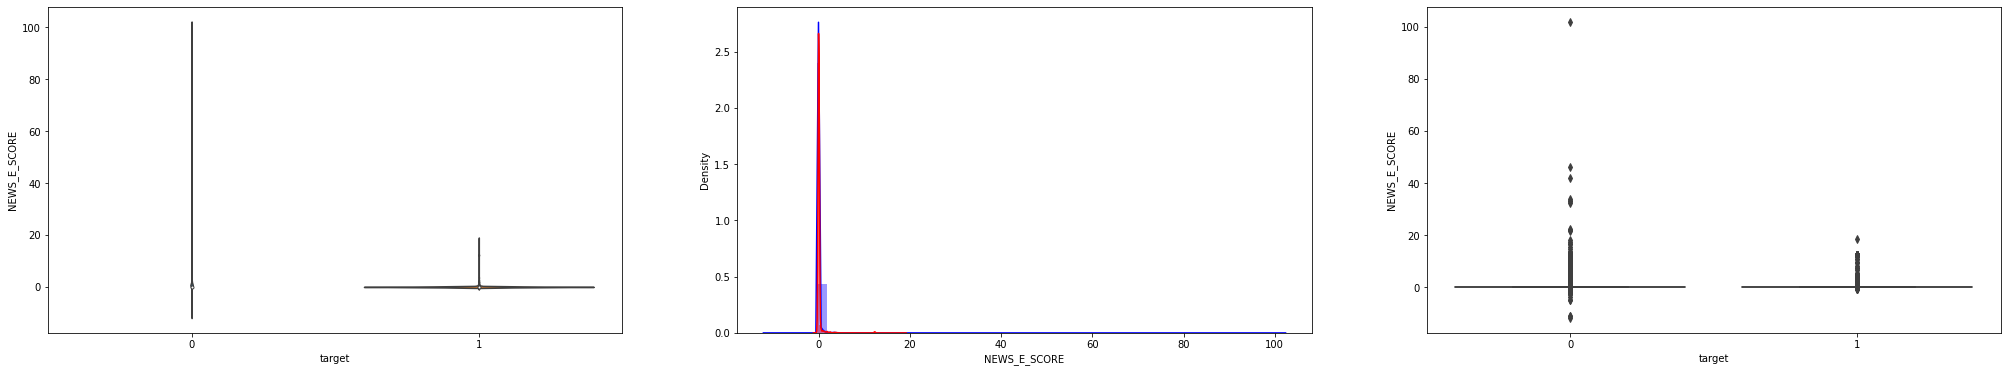

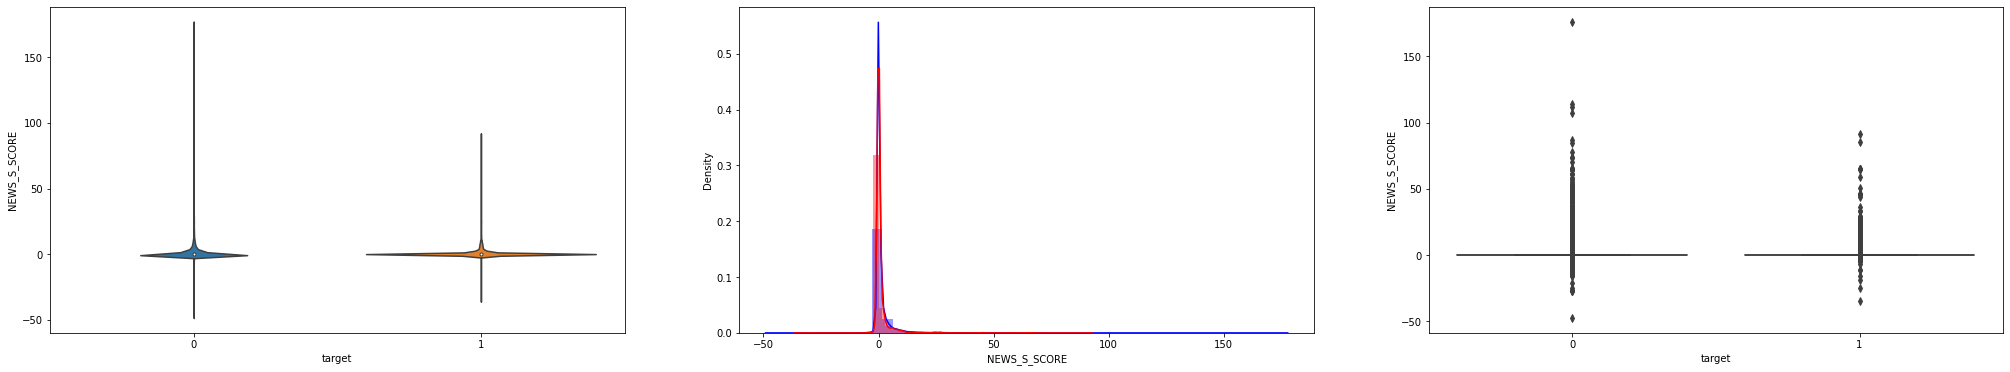

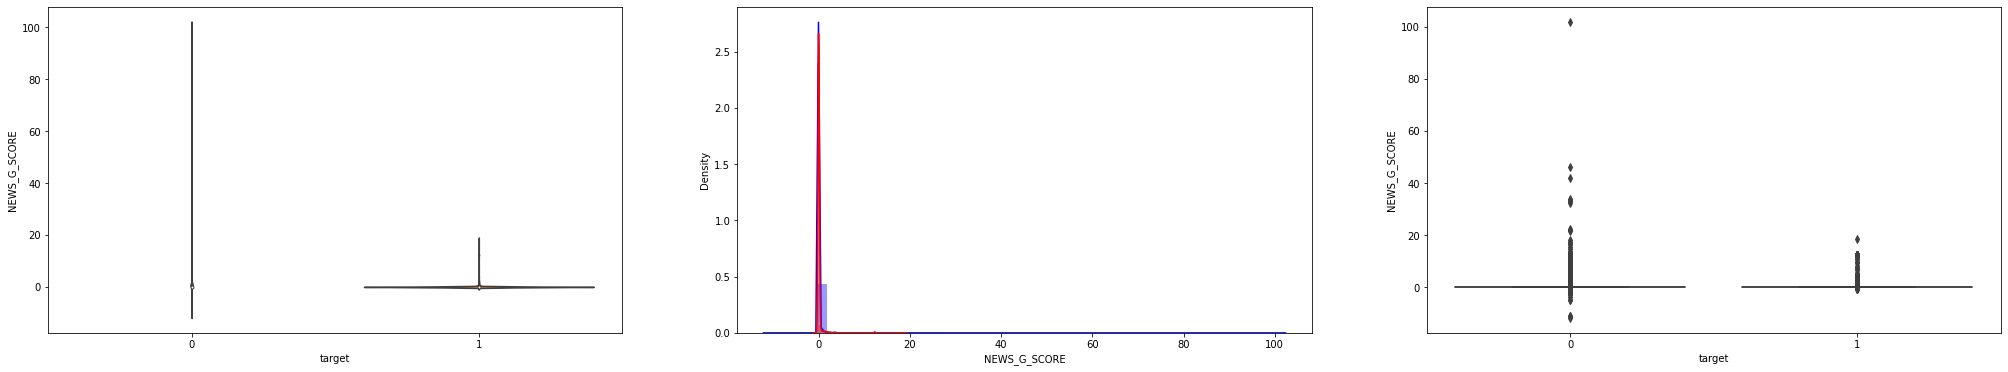

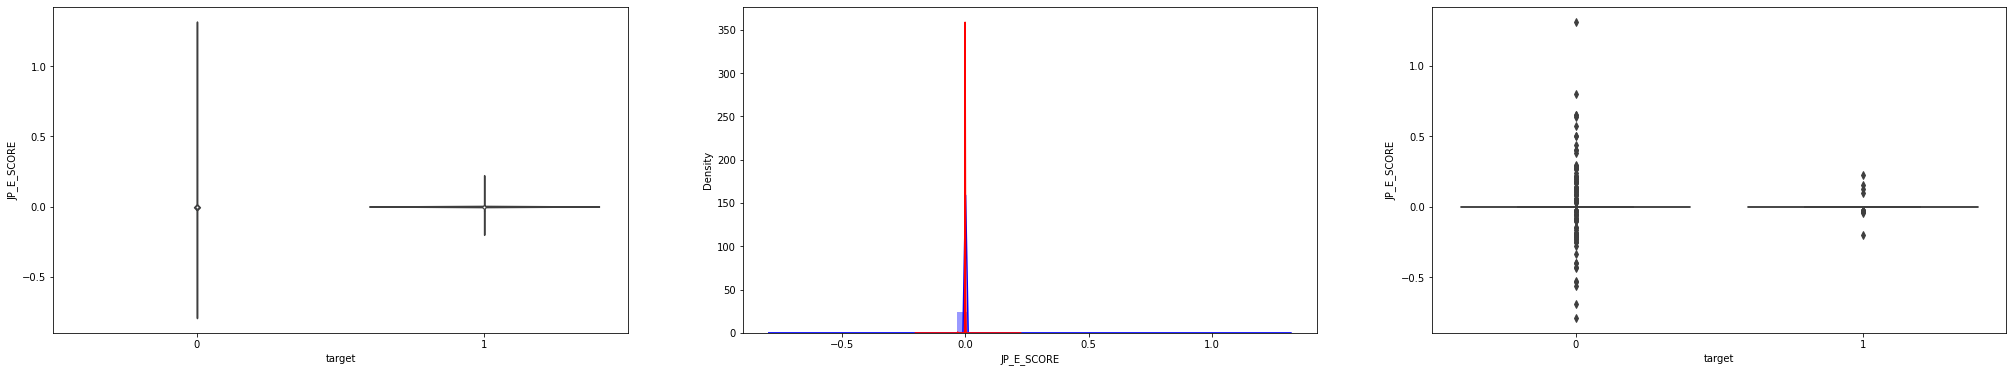

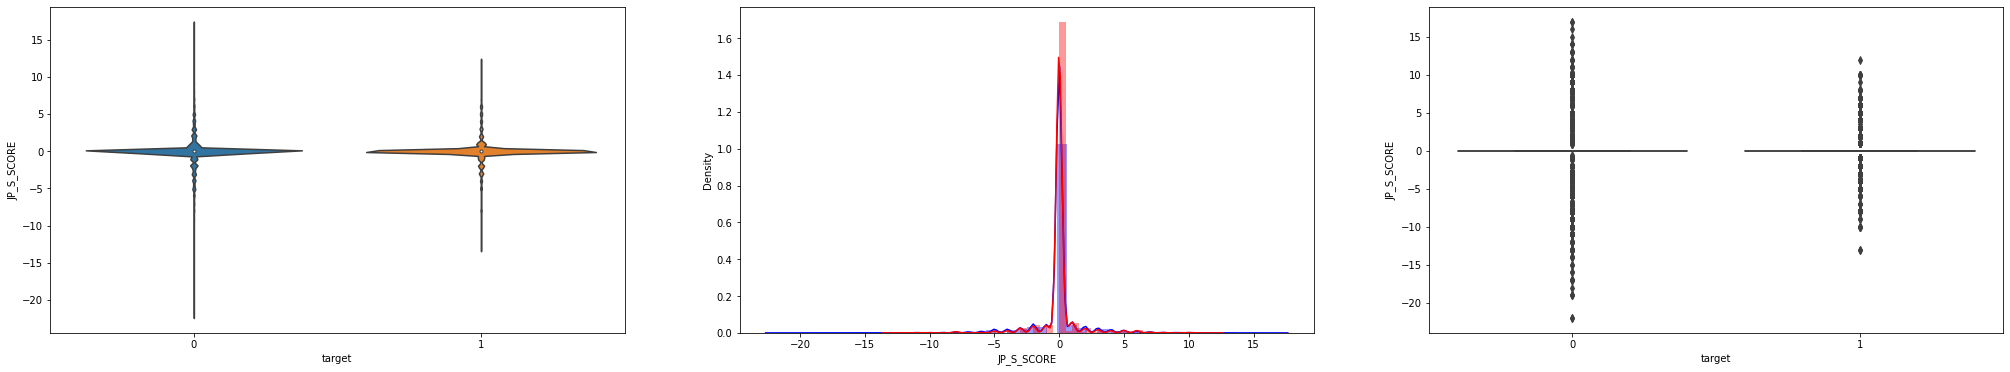

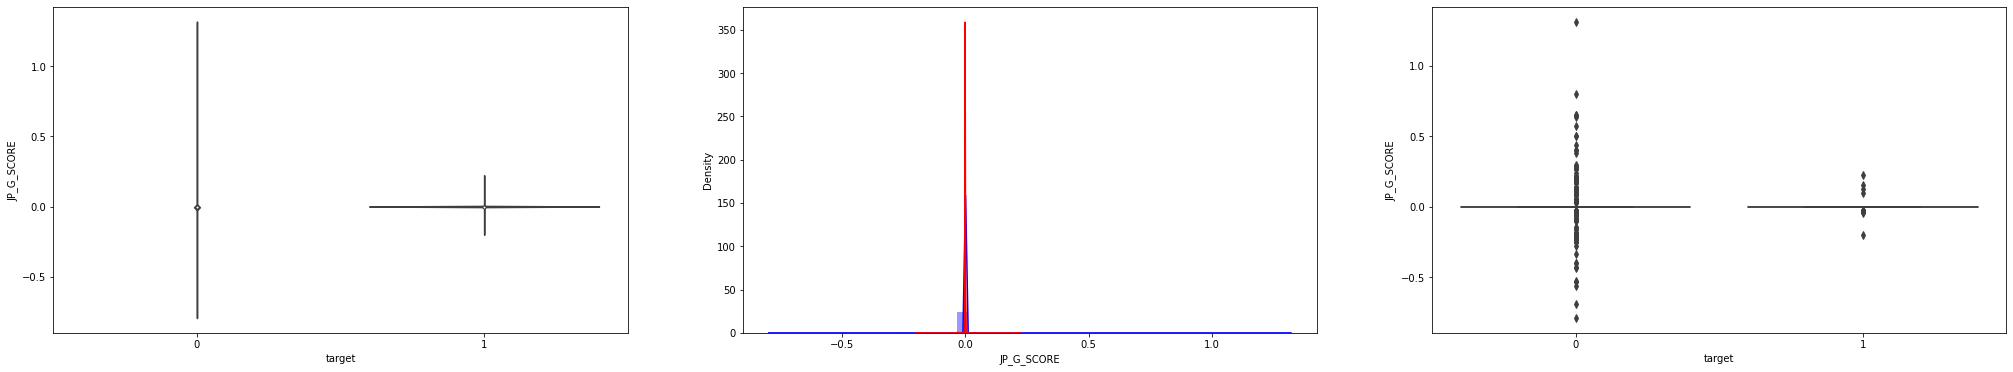

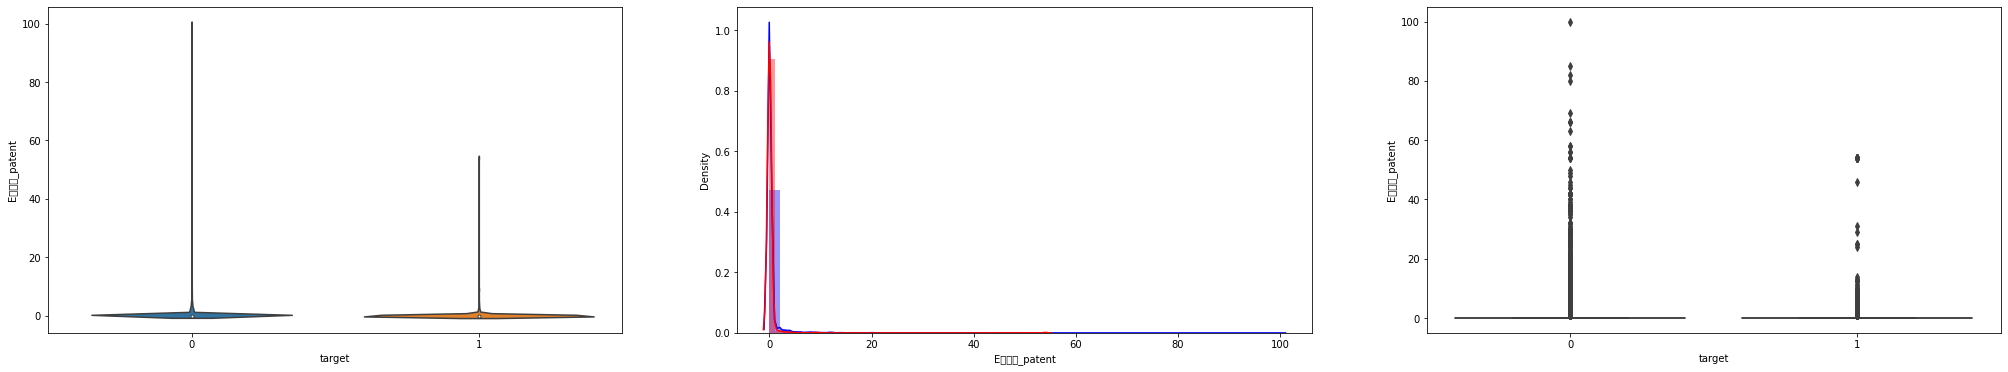

In [12]:
#생성된 ESG 스코어 분포 확인을 위해 df_ESG에 생성한 스코어 값 저장
df_ESG = df_new[['NEWS_E_SCORE','NEWS_S_SCORE','NEWS_G_SCORE','JP_E_SCORE','JP_S_SCORE','JP_G_SCORE','E카운트_patent','target']]

num_columns = df_ESG.dtypes[df_ESG.dtypes != 'object'].index.tolist()
# 숫자형 컬럼중 TARGET은 제외
num_columns = [column for column in num_columns if column not in['target']]
print(num_columns)

def show_hist_by_target(df, columns):
    cond_1 = (df['target'] == 1)
    cond_0 = (df['target'] == 0)
    
    for column in columns:
        print("column:", column)
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(35, 6), squeeze=False)
        # bureau는 특정 컬럼값이 infinite로 들어가있는 경우가 있음.  infinite일 경우 KDE histogram 시각화 시 문제 발생하여 이를 제거
        sns.violinplot(x='target', y=column, data=df[np.isfinite(df[column])], ax=axs[0][0])
        sns.distplot(df[cond_0 & np.isfinite(df[column])][column], label='0', color='blue', ax=axs[0][1])
        sns.distplot(df[cond_1 & np.isfinite(df[column])][column], label='1', color='red', ax=axs[0][1])
        sns.boxplot(x='target', y=column, data=df[np.isfinite(df[column])], ax=axs[0][2])


show_hist_by_target(df_ESG, num_columns)

In [13]:
import numpy as np
cond_1 = (df_ESG['target'] == 1)
cond_0 = (df_ESG['target'] == 0)

#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
print("NEWS_E_SCORE_F-TEST",f_test(df_ESG[cond_0]['NEWS_E_SCORE'], df_ESG[cond_1]['NEWS_E_SCORE']))
print("NEWS_S_SCORE_F-TEST",f_test(df_ESG[cond_0]['NEWS_S_SCORE'], df_ESG[cond_1]['NEWS_S_SCORE']))
print("NEWS_G_SCORE_F-TEST",f_test(df_ESG[cond_0]['NEWS_G_SCORE'], df_ESG[cond_1]['NEWS_G_SCORE']))
print("JP_E_SCORE_F-TEST",f_test(df_ESG[cond_0]['JP_E_SCORE'], df_ESG[cond_1]['JP_E_SCORE']))
print("JP_S_SCORE_F-TEST",f_test(df_ESG[cond_0]['JP_S_SCORE'], df_ESG[cond_1]['JP_S_SCORE']))
print("JP_G_SCORE_F-TEST",f_test(df_ESG[cond_0]['JP_G_SCORE'], df_ESG[cond_1]['JP_G_SCORE']))
print("E카운트_patent_F-TEST",f_test(df_ESG[cond_0]['E카운트_patent'], df_ESG[cond_1]['E카운트_patent']))

NEWS_E_SCORE_F-TEST (1.389910784338289, 1.1102230246251565e-16)
NEWS_S_SCORE_F-TEST (1.3356503143935365, 1.1102230246251565e-16)
NEWS_G_SCORE_F-TEST (1.389910784338289, 1.1102230246251565e-16)
JP_E_SCORE_F-TEST (17.80994847607008, 1.1102230246251565e-16)
JP_S_SCORE_F-TEST (1.6313517853718418, 1.1102230246251565e-16)
JP_G_SCORE_F-TEST (17.80994847607008, 1.1102230246251565e-16)
E카운트_patent_F-TEST (1.3597404167965823, 1.1102230246251565e-16)


In [14]:
df_ESG.describe()

,NEWS_E_SCORE,NEWS_S_SCORE,NEWS_G_SCORE,JP_E_SCORE,JP_S_SCORE,JP_G_SCORE,E카운트_patent,target
count,43763.000000,43763.000000,43763.000000,43763.000000,43763.000000,43763.000000,43763.000000,43763.000000
mean,0.098729,1.074266,0.098729,0.000070,-0.043038,0.000070,0.391998,0.213239
std,0.972359,4.188332,0.972359,0.015370,1.686487,0.015370,2.805830,0.409600
min,-11.760184,-47.524752,-11.760184,-0.789266,-21.994056,-0.789266,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,101.994205,176.180821,101.994205,1.312295,16.995279,1.312295,100.000000,1.000000


In [ ]:
df_new.to_csv('final_dataset.csv')

## 라. 변수 선정 및 전처리
- 1) 재무 데이터 모델 전처리 
- 2) 비재무 데이터 포함 모델 전처리 

## 1)재무 데이터 모델 전처리

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import sklearn
import gc
import scipy  
import seaborn as sns
from tqdm import notebook
import json
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import copy
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
#액티브 중소법인 재무보유 데이터 
actv = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/액티브 중소법인 재무보유.xlsx', sheet_name=0)
#휴폐업 중소법인 재무보유 
clos = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/휴폐업 중소법인 재무보유.xlsx', sheet_name=0)
# 재무데이터 
finance = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/넘블 나이스 디앤비 챌린지/1. 원본 데이터/재무데이터.txt", sep = "\t", engine='python', encoding = "cp949")

#데이터 결합 
actv['target'] = 0 #종속변수 생성 
clos['target'] = 1
actv.rename(columns = {'CMP_NM1':'CMP_NM'}, inplace=True )
df_origin = pd.concat([actv,clos], axis = 0)

print(df_origin.shape)
df_origin.head()

(35721, 29)


,BIZ_NO,CMP_PFIX_NM,CMP_NM,CMP_SFIX_NM,CMP_ENM,BZ_TYP,CMP_SCL,PBCO_GB,PSN_CORP_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,IND_CD_ORDR,IND_CD1,IND_CD2,IND_CD3,PB_ORG_TYP,MDSCO_PRTC_YN,HDOF_CMP_CD,ESTB_DATE,ESTB_GB,LIST_DATE,MN_BIZ_CONT,NATN_NM,HOMEPAGE_URL,CEO_NM,EMP_CNT,target
0,1138111739,NaN,한일가스산업,(주),"HANIL GAS IND. CO.,LTD.",M,2,2,1,1,N,N,NaN,10.0,47712.0,NaN,NaN,0,N,NaN,19660419.0,1,NaN,LP Gas 충전 및 판매업,NaN,www.hanilgas.com,홍순철외 1명,43.0,0
1,2078132193,(주),엠피아이,NaN,"EMPIALEE CO.,LTD.",M,2,2,1,1,N,N,NaN,10.0,15190.0,NaN,NaN,0,N,NaN,19910806.0,1,NaN,가죽 및 대용가죽제품 제조업,NaN,www.mastercnd.co.kr,이스테판상수외 1명,35.0,0
2,1318167565,NaN,도영운수,(주),"DOYOUNG TRANSPORTATION CO.,LTD.",M,2,2,1,1,N,N,NaN,10.0,49212.0,NaN,NaN,0,N,NaN,20011030.0,1,NaN,시내버스업,NaN,transport@naver.com,김명화,149.0,0
3,5048128251,(주),중원산업,NaN,"JOONGWON INDUSTRIAL CO.,LTD.",M,2,2,1,1,N,N,NaN,10.0,30391.0,NaN,NaN,0,N,NaN,19990112.0,1,NaN,자동차 부품 제조,NaN,www.koreajw.com,김명구,75.0,0
4,1098164260,(주),카타나골프,NaN,"CATANA GOLF CO.,LTD.",M,2,2,1,1,N,N,NaN,10.0,46800.0,NaN,NaN,0,N,NaN,20000531.0,1,NaN,골프용품 전반의 제조 및 수출업,NaN,NaN,김홍득,3.0,0


In [ ]:
#불필요한 변수 삭제 
df_origin.drop(['CMP_PFIX_NM','CMP_SFIX_NM','BZ_TYP','CMP_ENM','CMP_SCL','PBCO_GB','PSN_CORP_GB','LIST_CD','PB_ORG_TYP','IND_CD_ORDR','ESTB_GB','LIST_DATE','NATN_NM','HOMEPAGE_URL','CEO_NM','IND_CD2','IND_CD3','ESTB_DATE'], axis=1, inplace=True)

''' drop 변수 설명 
BZ_TYP [업종] : 대부분 제조업
CMP_SCL [기업규모] : 모두 2 (중소기업)
PBCO_GB [공기업구분] : 대부분 2 (일반기업)
PSN_CORP_GB [개인법인구분] : 모두 1 (법인)
LIST_CD [상장코드] / LIST_DATE[상장일자]: 대다수가 결측치 
IND_CD_ORDR [산업코드차수] : 모두 10 
PB_ORG_TYP [공공기관유형] : 대부분 0 (해당사항없음)
ESTB_GB [설립구분] : 대부분 1 (주식회사)
NATN_NM [국가명]
HOMEPAGE_URL [홈페이지 주소]
CEO_NM [CEO 이름]
ESTB_GB [설립일자]
'''

df_origin.shape

(35721, 11)

In [ ]:
## categorical 변수 인코딩 

# FR_IVST_CORP_YN [해외법인 투자 유무] : 더미화 
df_origin['FR_IVST_CORP_YN'].value_counts() 
df_origin['FR_IVST_CORP_YN'] = df_origin['FR_IVST_CORP_YN'].astype('category').cat.codes #0,1로 인코딩 

# HDOF_BR_GB [본점/지점] : 더미화 
df_origin['HDOF_BR_GB'].value_counts() 
df_origin['HDOF_BR_GB'] = df_origin['HDOF_BR_GB'].astype('category').cat.codes #0,1로 인코딩 

# MDSCO_PRTC_YN [중견기업 보호 여부] : 더미화 
df_origin['MDSCO_PRTC_YN'] = df_origin['MDSCO_PRTC_YN'].astype('category').cat.codes #0,1로 인코딩 

# VENT_YN [벤처기업 여부] : 더미화 
df_origin['VENT_YN'] = df_origin['VENT_YN'].astype('category').cat.codes #0,1로 인코딩 

In [ ]:
#재무데이터 결합
#결산년월 기준 가장 최신 값을 변수로 
finance_newest = finance.sort_values(by='결산년월', ascending=False).groupby('사업자번호', sort=False).head(1)
finance_newest.rename(columns = {'사업자번호':'BIZ_NO'}, inplace=True )

print(finance_newest.shape)

(35709, 46)


In [ ]:
#기업정보 데이터와 재무 데이터 join 
df_origin_merg = df_origin.merge(finance_newest,on='BIZ_NO',how='inner')

#종속변수 앞으로 이동
cols = list(df_origin_merg) 
cols.insert(0, cols.pop(cols.index('target')))
df_origin_final = df_origin_merg.loc[:, cols] #재 정렬 
df_origin_final.head() 

,target,BIZ_NO,CMP_NM,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,IND_CD1,MDSCO_PRTC_YN,HDOF_CMP_CD,MN_BIZ_CONT,EMP_CNT,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,자본금,이익잉여금(결손금）,자본총계,매출액,판매비와관리비,영업이익（손실）,법인세비용차감전순손익,법인세비용,당기순이익(손실),기업순이익률(%),유보액/총자산(%),유보액/납입자본(%),매출액총이익률(%),매출액영업이익률(%),매출액순이익률(%),수지비율(%),경상수지비율,영업비율(%),금융비용대매출액비율(%,금융비용대부채비율(%),금융비용대총비용비율(%,부채비율(%),차입금의존도(%),자기자본비율(%),순운전자본비율(%),유동부채비율(%),비유동부채비율(%),부채총계대 매출액(%),총자본회전율(회),재고자산회전율(회),매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산
0,0,1138111739,한일가스산업,0,0,0,47712.0,0,NaN,LP Gas 충전 및 판매업,43.0,20211231,2758846.0,1577971.0,11235042.0,5705994.0,13993889.0,6172590.0,6343124.0,12515714.0,300000.0,1178175.0,1478175.0,19738142.0,5176975.0,-979131.0,-812712.0,NaN,-812712.0,1.000000e+12,8.419,392.725,21.268,-4.961,-4.118,104.027,-2.099712e+06,104.961,0.323,1.000000e+12,0.303,846.700,24.165,10.563,-24.395,417.582,429.119,63.409,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,100333.0,15540298.0,25000.0,59170.0
1,0,2078132193,엠피아이,0,0,0,15190.0,0,NaN,가죽 및 대용가죽제품 제조업,35.0,20211231,5562280.0,1443248.0,8236579.0,4351158.0,13798860.0,5247799.0,4002659.0,9250457.0,100000.0,4448402.0,4548402.0,14889722.0,765533.0,452145.0,391144.0,13605.0,377539.0,3.881000e+00,32.238,4448.402,8.178,3.037,2.536,97.398,-1.352845e+06,96.963,1.076,1.687000e+00,1.094,203.378,40.451,32.962,2.279,115.377,88.001,62.127,1.074000e+00,5.800000e+00,1.114000e+01,1.271000e+01,429334.0,13672044.0,208.0,2324076.0
2,0,1318167565,도영운수,0,0,0,49212.0,0,NaN,시내버스업,149.0,20211231,1965055.0,1389692.0,4358581.0,4232380.0,6323635.0,3749079.0,1024357.0,4773436.0,200000.0,1350200.0,1550200.0,12582033.0,897080.0,-20771.0,-482373.0,NaN,-482373.0,-6.641000e+00,21.352,675.100,6.965,-0.165,-3.834,103.824,1.595847e+03,100.165,0.383,1.016000e+00,0.368,307.924,23.993,24.514,-28.212,241.845,66.079,37.939,1.925000e+00,1.000000e+12,9.850000e+00,6.704500e+01,520.0,11705724.0,917.0,NaN
3,0,5048128251,중원산업,0,0,0,30391.0,0,NaN,자동차 부품 제조,75.0,20211231,12668826.0,5749707.0,15954138.0,13741069.0,28622964.0,9393776.0,3998392.0,13392168.0,50000.0,15180796.0,15230796.0,35437416.0,3491275.0,2124877.0,3044086.0,618646.0,2425439.0,9.158000e+00,49.543,28361.592,15.848,5.996,6.844,91.682,-4.780308e+06,94.004,0.351,9.240000e-01,0.371,87.928,18.874,53.212,11.442,61.676,26.252,37.791,1.273000e+00,4.920100e+01,6.387000e+00,7.718000e+00,11688.0,29821265.0,474611.0,1035680.0
4,0,1098164260,카타나골프,0,0,0,46800.0,0,NaN,골프용품 전반의 제조 및 수출업,3.0,20211231,10804850.0,137054.0,1146992.0,980971.0,11951841.0,6960351.0,4780000.0,11740351.0,100000.0,111490.0,211490.0,1172000.0,479947.0,12032.0,-146752.0,44086.0,-190838.0,-1.390000e-01,0.933,111.490,41.978,1.027,-16.283,112.266,1.000000e+12,98.973,14.747,1.364000e+00,12.867,5551.256,73.186,1.770,32.167,3291.102,2260.154,1001.736,9.000000e-02,1.440000e+00,3.294000e+00,4.184000e+00,24272.0,680021.0,NaN,815935.0


In [ ]:
# 결측치 
df_origin_final.isnull().sum()
df_origin_final.fillna(0, inplace=True) #결측치 0으로 대체 

## 2) 비재무 데이터 포함 모델 전처리


In [ ]:
df_esg = pd.read_csv('/content/drive/MyDrive/넘블공모전/final_dataset.csv', index_col=0)
df_esg.head()
df_esg.shape

(43763, 43)

In [ ]:
#불필요한 변수 삭제 
df_esg.drop(['CMP_PFIX_NM','CMP_NM','CMP_SFIX_NM','BZ_TYP','CMP_ENM','CMP_SCL','PBCO_GB','PSN_CORP_GB',
               'LIST_CD','PB_ORG_TYP','IND_CD_ORDR','ESTB_GB','LIST_DATE','NATN_NM','HOMEPAGE_URL','CEO_NM','IND_CD2','IND_CD3','ESTB_DATE','CMP_NM_PFIX_SFIX'], axis=1, inplace=True)

''' drop 변수 설명 
BZ_TYP [업종] : 거의다 제조업이라 삭제 
CMP_SCL [기업규모] : 모두 2 (중소기업)
PBCO_GB [공기업구분] : 대부분 2 (일반기업)
PSN_CORP_GB [개인법인구분] : 모두 1 (법인)
LIST_CD [상장코드] / LIST_DATE[상장일자]: 대다수가 결측치 
IND_CD_ORDR [산업코드차수] : 모두 10 
PB_ORG_TYP [공공기관유형] : 대부분 0 (해당사항없음)
ESTB_GB [설립구분] : 대부분 1 (주식회사)
NATN_NM [국가명]
HOMEPAGE_URL [홈피 주소]
CEO_NM [CEO 이름]
ESTB_GB [설립일자]
'''
df_esg.shape

(43763, 23)

In [ ]:
## categorical 변수 인코딩 

# FR_IVST_CORP_YN [해외법인 투자 유무] : 더미화 
df_esg['FR_IVST_CORP_YN'].value_counts() 
df_esg['FR_IVST_CORP_YN'] = df_esg['FR_IVST_CORP_YN'].astype('category').cat.codes #0,1로 인코딩 

# HDOF_BR_GB [본점/지점] : 더미화 
df_esg['HDOF_BR_GB'].value_counts() 
df_esg['HDOF_BR_GB'] = df_esg['HDOF_BR_GB'].astype('category').cat.codes #0,1로 인코딩 

# MDSCO_PRTC_YN [중견기업 보호 여부] : 더미화 
df_esg['MDSCO_PRTC_YN'] = df_esg['MDSCO_PRTC_YN'].astype('category').cat.codes #0,1로 인코딩 

# VENT_YN [벤처기업 여부] : 더미화 
df_esg['VENT_YN'] = df_esg['VENT_YN'].astype('category').cat.codes #0,1로 인코딩 


#### 재무 데이터 전처리

In [ ]:
#기업정보 데이터와 재무 데이터 join 
df_esg_merg = df_esg.merge(finance_newest,on='BIZ_NO',how='inner')

#종속변수 앞으로 이동
cols = list(df_esg_merg) 
cols.insert(0, cols.pop(cols.index('target')))
df_esg_final = df_esg_merg.loc[:, cols] #재 정렬 
df_esg_final.head() 

,target,BIZ_NO,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,IND_CD1,MDSCO_PRTC_YN,HDOF_CMP_CD,MN_BIZ_CONT,EMP_CNT,E카운트_patent,score_news,ratio_news,score_jp,ratio_jp,Industy_code,Industy_name,NEWS_E_SCORE,NEWS_S_SCORE,NEWS_G_SCORE,JP_E_SCORE,JP_S_SCORE,JP_G_SCORE,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,자본금,이익잉여금(결손금）,자본총계,매출액,판매비와관리비,영업이익（손실）,법인세비용차감전순손익,법인세비용,당기순이익(손실),기업순이익률(%),유보액/총자산(%),유보액/납입자본(%),매출액총이익률(%),매출액영업이익률(%),매출액순이익률(%),수지비율(%),경상수지비율,영업비율(%),금융비용대매출액비율(%,금융비용대부채비율(%),금융비용대총비용비율(%,부채비율(%),차입금의존도(%),자기자본비율(%),순운전자본비율(%),유동부채비율(%),비유동부채비율(%),부채총계대 매출액(%),총자본회전율(회),재고자산회전율(회),매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산
0,0,1138111739,0,0,0,47712.0,0,NaN,LP Gas 충전 및 판매업,43.0,0.0,0.0,0.00,0.0,NaN,47712.0,차량용 가스 충전업,0.0,0.000000,0.0,0.0,0.0,0.0,20211231,2758846.0,1577971.0,11235042.0,5705994.0,13993889.0,6172590.0,6343124.0,12515714.0,300000.0,1178175.0,1478175.0,19738142.0,5176975.0,-979131.0,-812712.0,NaN,-812712.0,1.000000e+12,8.419,392.725,21.268,-4.961,-4.118,104.027,-2099711.928,104.961,0.323,1.000000e+12,0.303,846.700,24.165,10.563,-24.395,417.582,429.119,63.409,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,100333.0,15540298.0,25000.0,59170.0
1,0,2078132193,0,0,0,15190.0,0,NaN,가죽 및 대용가죽제품 제조업,35.0,0.0,1.0,0.59,0.0,NaN,15190.0,기타 가죽제품 제조업,0.0,0.999445,0.0,0.0,0.0,0.0,20211231,5562280.0,1443248.0,8236579.0,4351158.0,13798860.0,5247799.0,4002659.0,9250457.0,100000.0,4448402.0,4548402.0,14889722.0,765533.0,452145.0,391144.0,13605.0,377539.0,3.881000e+00,32.238,4448.402,8.178,3.037,2.536,97.398,-1352845.013,96.963,1.076,1.687000e+00,1.094,203.378,40.451,32.962,2.279,115.377,88.001,62.127,1.074000e+00,5.800000e+00,1.114000e+01,1.271000e+01,429334.0,13672044.0,208.0,2324076.0
2,0,2078132193,0,0,0,15190.0,0,NaN,가죽 및 대용가죽제품 제조업,35.0,0.0,1.0,0.59,0.0,NaN,15190.0,기타 가죽제품 제조업,0.0,0.999445,0.0,0.0,0.0,0.0,20211231,5562280.0,1443248.0,8236579.0,4351158.0,13798860.0,5247799.0,4002659.0,9250457.0,100000.0,4448402.0,4548402.0,14889722.0,765533.0,452145.0,391144.0,13605.0,377539.0,3.881000e+00,32.238,4448.402,8.178,3.037,2.536,97.398,-1352845.013,96.963,1.076,1.687000e+00,1.094,203.378,40.451,32.962,2.279,115.377,88.001,62.127,1.074000e+00,5.800000e+00,1.114000e+01,1.271000e+01,429334.0,13672044.0,208.0,2324076.0
3,0,1318167565,0,0,0,49212.0,0,NaN,시내버스업,149.0,0.0,0.0,0.00,0.0,NaN,49212.0,시내버스 운송업,0.0,0.000000,0.0,0.0,0.0,0.0,20211231,1965055.0,1389692.0,4358581.0,4232380.0,6323635.0,3749079.0,1024357.0,4773436.0,200000.0,1350200.0,1550200.0,12582033.0,897080.0,-20771.0,-482373.0,NaN,-482373.0,-6.641000e+00,21.352,675.100,6.965,-0.165,-3.834,103.824,1595.847,100.165,0.383,1.016000e+00,0.368,307.924,23.993,24.514,-28.212,241.845,66.079,37.939,1.925000e+00,1.000000e+12,9.850000e+00,6.704500e+01,520.0,11705724.0,917.0,NaN
4,0,5048128251,0,0,0,30391.0,0,NaN,자동차 부품 제조,75.0,0.0,0.0,NaN,0.0,NaN,30391.0,자동차용 동력전달장치 제조업,0.0,0.000000,0.0,0.0,0.0,0.0,20211231,12668826.0,5749707.0,15954138.0,13741069.0,28622964.0,9393776.0,3998392.0,13392168.0,50000.0,15180796.0,15230796.0,35437416.0,3491275.0,2124877.0,3044086.0,618646.0,2425439.0,9.158000e+00,49.543,28361.592,15.848,5.996,6.844,91.682,-4780308.293,94.004,0.351,9.240000e-01,0.371,87.928,18.874,53.212,11.442,61.676,26.252,37.791,1.273000e+00,4.920100e+01,6.387000e+00,7.718000e+00,11688.0,29821265.0,474611.0,1035680.0


In [ ]:
# 이상치 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

#boxplot 확인 
for i in df.columns[13:]:
    sns.boxplot(x = i, data = df)
    plt.show()

for i in df.columns[13:]:
    q = df[i].quantile(0.999)
    print('변수명 :',i)
    print('조건 해당 row 수:', len(df[df[i] > q][['CMP_NM','MN_BIZ_CONT',i]]))
    print(df[df[i] > q][['CMP_NM',i,'MN_BIZ_CONT']])
    print('\n')

In [ ]:
# 결측치 
df_esg_final.isnull().sum()
df_esg_final.fillna(0, inplace=True) #결측치 0으로 대체 

###  3) EDA

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

#font_path = 'C:\\NiceDNB\\넘블 챌린지 데이터\\NanumGothic.ttf'
#font_name = fm.FontProperties(fname=font_path, size=10).get_name()
#plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()
#mpl.pyplot.rc('font', family='NanumGothic')

data = copy.deepcopy(df_concat)

In [ ]:
#업종 분류
data['BZ_TYP'].value_counts()/len(data['BZ_TYP'])

M    0.988634
O    0.008538
A    0.001372
V    0.001120
S    0.000224
F    0.000056
B    0.000028
I    0.000028
Name: BZ_TYP, dtype: float64

<AxesSubplot: >

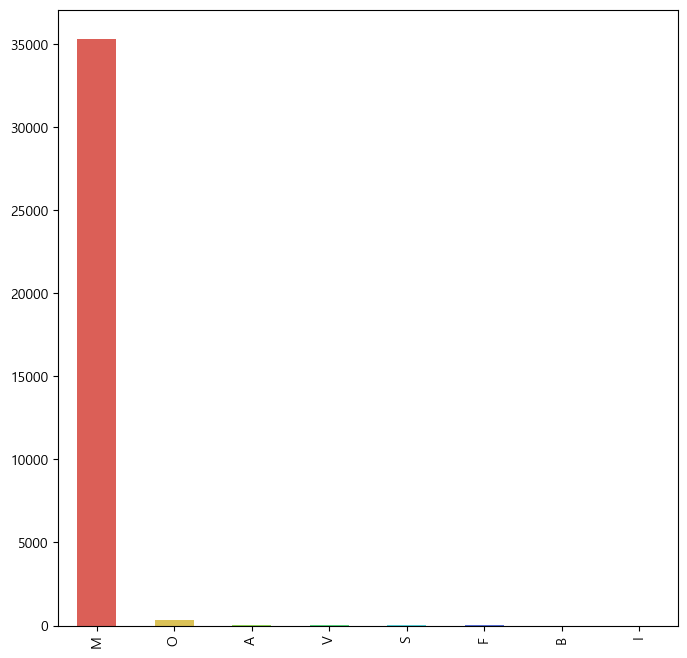

In [ ]:
colors = sns.color_palette('hls',len(data['BZ_TYP'].value_counts())) ## 색상 지정

plt.figure(figsize=(8,8))
data['BZ_TYP'].value_counts().plot.bar( color=colors)

In [ ]:
#중소기업 100%
data['CMP_SCL'].value_counts()/len(data['CMP_SCL'])

2    1.0
Name: CMP_SCL, dtype: float64

<AxesSubplot: >

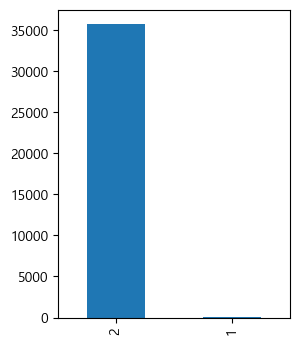

In [ ]:

plt.figure(figsize=(3,4))
data['PBCO_GB'].value_counts().plot.bar()

In [ ]:
#본점 87%
#지점 12%
data['HDOF_BR_GB'].value_counts()/len(data['HDOF_BR_GB'])

1    0.877467
2    0.122533
Name: HDOF_BR_GB, dtype: float64

<AxesSubplot: >

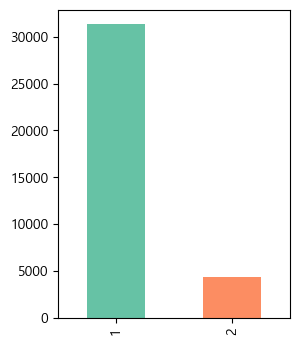

In [ ]:
colors = sns.color_palette('Set2',len(data['HDOF_BR_GB'].value_counts())) ## 색상 지정

plt.figure(figsize=(3,4))
data['HDOF_BR_GB'].value_counts().plot.bar(color=colors)

In [ ]:
#법인 100%
data['PSN_CORP_GB'].value_counts()/len(data['PSN_CORP_GB'])

1    1.0
Name: PSN_CORP_GB, dtype: float64

In [ ]:
# 3:지자체공단/공사 2 공기업/준정부기관 0 해당없음
data['PB_ORG_TYP'].value_counts()/len(data['PB_ORG_TYP'])

0    0.999020
3    0.000812
2    0.000168
Name: PB_ORG_TYP, dtype: float64

In [ ]:
data['target'].value_counts()/len(data['target'])

0    0.811343
1    0.188657
Name: target, dtype: float64

<AxesSubplot: >

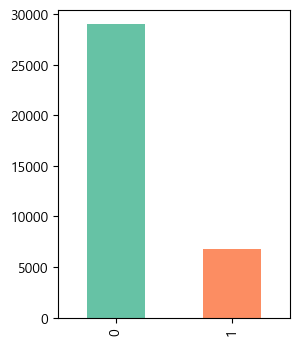

In [ ]:
#타겟 비율 : => 1:18.8%, 0:81.2%
colors = sns.color_palette('Set2',len(data['target'].value_counts())) ## 색상 지정
plt.figure(figsize=(3,4))
data['target'].value_counts().plot.bar(color=colors)

In [ ]:
data.groupby(by='IND_CD1')['BIZ_NO'].count().sort_values(ascending=False)

IND_CD1
68129.0    1271
68112.0     847
68121.0     500
30391.0     495
68122.0     473
           ... 
25995.0       1
25130.0       1
25123.0       1
72920.0       1
1100.0        1
Name: BIZ_NO, Length: 1413, dtype: int64

In [ ]:
df_ksic=df_ksic.astype({'Industy_code':'float'})
data_ksic = data.merge(df_ksic,left_on='IND_CD1',right_on='Industy_code',how='left')
Industry=data_ksic.groupby('Industy_name')['target'].sum().sort_values(ascending=False)/len(data_ksic.groupby('Industy_name')['target'].sum())

<AxesSubplot: xlabel='Industy_name'>

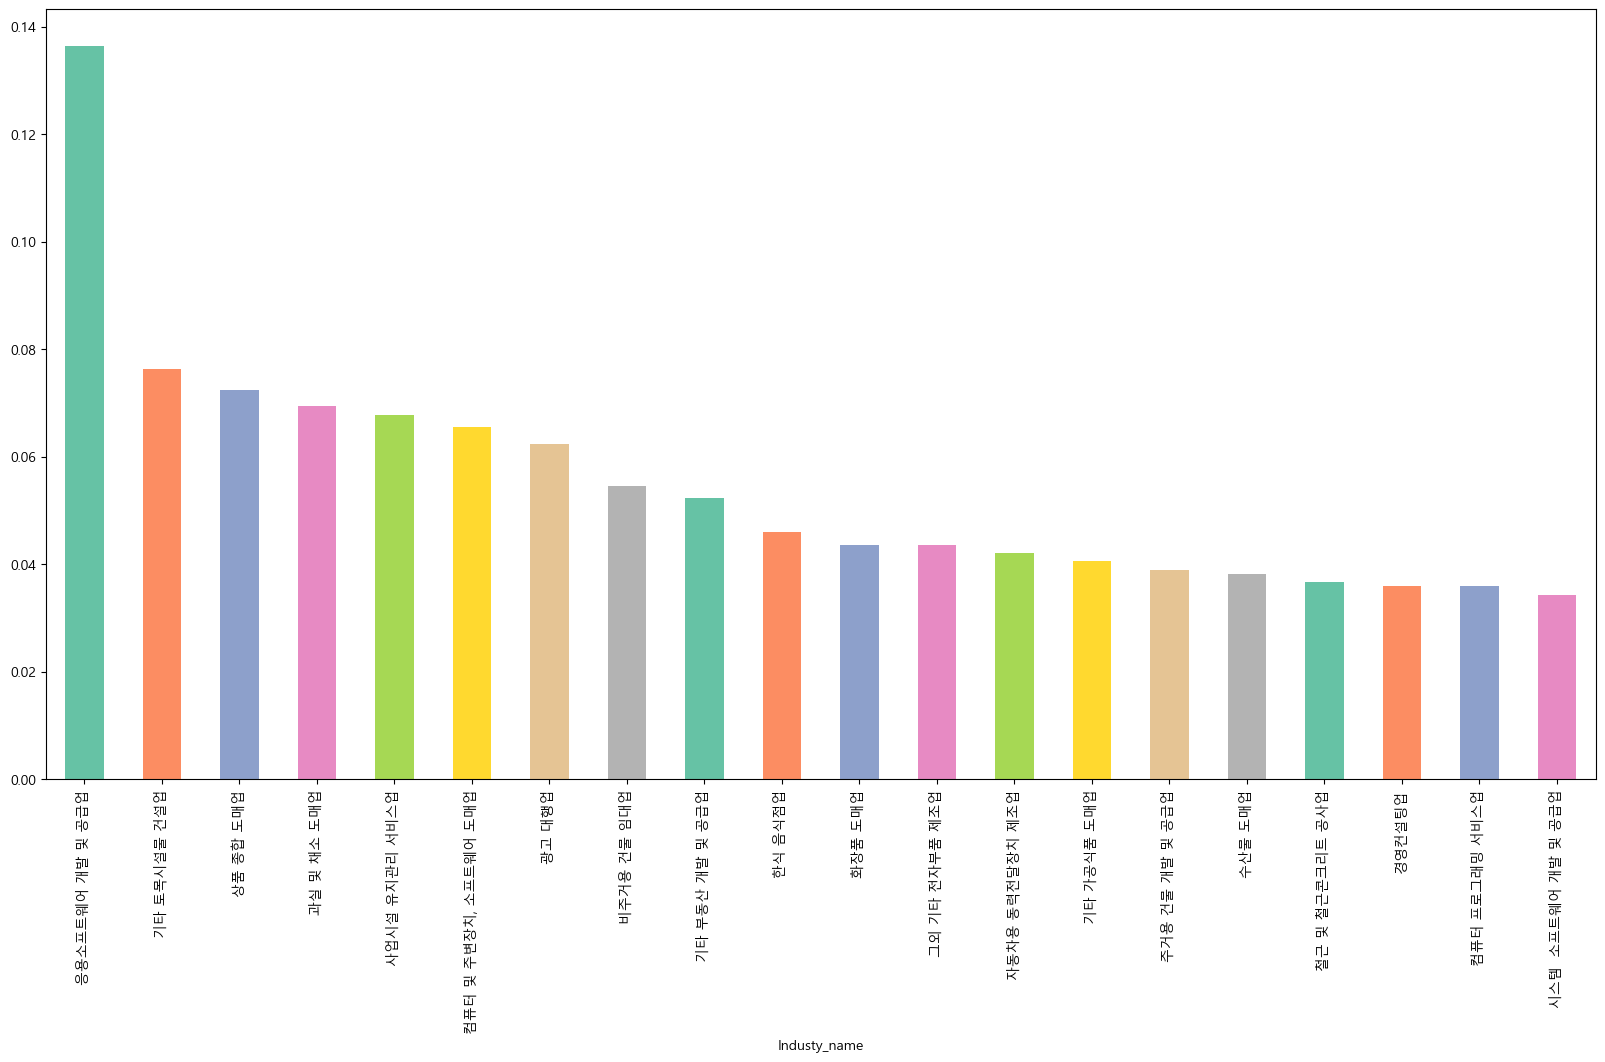

In [ ]:
colors = sns.color_palette('Set2',len(Industry[:20])) ## 색상 지정

Industry[:20].plot.bar(color=colors)

# 예측 모델 개발
- 가. 재무 데이터 모델 (기본모델)
- 나. 비재무 데이터 포함 모델 

## 가. 기본 모델 학습
- 기업 정보 데이터 + 재무 데이터 

### 1) Train/Test 데이터 분리
- train : test = 8 : 2 비율로 분리
- train set을 이용하여 변수선정, 샘플링, 표준화 진행 
- test set을 이용하여 최종 성능 비교 

In [ ]:
from sklearn.model_selection import train_test_split 

# string 변수 삭제
df_origin_final.drop(['CMP_NM', 'MN_BIZ_CONT','결산년월','IND_CD1' ], axis=1, inplace=True)
# BIZ_NO를 인덱스로 설정 
df_origin_final = df_origin_final.set_index('BIZ_NO')
# train/test split 
X = df_origin_final.iloc[:, 1:] 
y = df_origin_final['target'] 

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1) 

### 2) Oversampling (SMOTE)
- Synthetic Minority Over-Sampling Technique 사용 
- 휴폐업 기업의 데이터가 상대적으로 부족하므로 증가시킴 

In [ ]:
#SMOTE 알고리즘을 이용한 오버샘플링 
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

print(y_train.value_counts()) #클래스 불균형 확인 

smote = SMOTE(sampling_strategy = 'minority') #minor class만 증가시키기 
x_train_over, y_train_over = smote.fit_resample(x_train, y_train) #변수 선정 X 
#x_train_over, y_train_over = smote.fit_resample(x_train_selected, y_train) #변수 선정 O

print(y_train_over.value_counts()) #오버샘플링 결과 확인 

0    23182
1     5385
Name: target, dtype: int64
0    23182
1    23182
Name: target, dtype: int64


### 3). 변수 표준화 (Standardization)
- Standard Scaler를 이용하여 모든 변수 표준화 진행 
- 평균=0, 분산 =1 인 분포로 변환 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

x_train_norm = pd.DataFrame(scaler.fit_transform(x_train_over), columns = x_train.columns)
x_test_norm = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns )

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression

### Logistic Regression 모델 

In [ ]:
#로지스틱 회귀 모델 학습 
LR = LogisticRegression()

LR.fit(x_train_norm, y_train_over) 
y_test_pred = LR.predict(x_test_norm) 
logit_proba = LR.predict_proba(x_test_norm)[:, 1] 

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.94      0.82      0.87      5796
           1       0.49      0.77      0.60      1346

    accuracy                           0.81      7142
   macro avg       0.72      0.80      0.74      7142
weighted avg       0.86      0.81      0.82      7142



### Decision Tree 모델

In [ ]:
#의사결정나무 모델 학습
from sklearn import tree
tree = tree.DecisionTreeClassifier()

tree.fit(x_train_norm, y_train_over)
y_test_pred = tree.predict(x_test_norm)
dt_proba = tree.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5796
           1       0.69      0.80      0.74      1346

    accuracy                           0.89      7142
   macro avg       0.82      0.86      0.84      7142
weighted avg       0.90      0.89      0.90      7142



### Random Forest 모델 

In [ ]:
#랜덤 포레스트 모델 학습
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()

#테스트셋 평가 
RF.fit(x_train_norm,y_train_over)
y_test_pred = RF.predict(x_test_norm)
rf_proba = RF.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5796
           1       0.85      0.80      0.82      1346

    accuracy                           0.94      7142
   macro avg       0.90      0.88      0.89      7142
weighted avg       0.93      0.94      0.94      7142



### Support Vector Machine 모델

In [ ]:
#SVM 모델 학습 
import sklearn.svm as svm
svm_clf =svm.SVC(probability=True, kernel = 'rbf')
svm_clf.fit(x_train_norm,y_train_over)

y_test_pred = svm_clf.predict(x_test_norm)
svm_proba = svm_clf.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5796
           1       0.66      0.83      0.73      1346

    accuracy                           0.89      7142
   macro avg       0.81      0.86      0.83      7142
weighted avg       0.90      0.89      0.89      7142



### LGBM 모델 

In [ ]:
#LGBM 모델 학습 
import lightgbm as lgb
from numpy import argmax 
from lightgbm import LGBMClassifier
 
final_params = {}

lgb_train = lgb.Dataset(x_train_norm, y_train_over)
num_round = 100
lgb_model = lgb.train(final_params, lgb_train, num_round)

#예측
y_pred_val = lgb_model.predict(x_test_norm)
lgb_proba = lgb_model.predict(x_test_norm)

print(y_pred_val) 

#cutoff 조정 
y_test_pred = pd.Series(y_pred_val).apply(lambda x: 1 if x>=0.5 else 0) 
print(classification_report(y_test, y_test_pred))

[0.08198174 0.07062618 0.00665216 ... 0.03442242 0.01766334 0.02020387]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5796
           1       0.80      0.83      0.82      1346

    accuracy                           0.93      7142
   macro avg       0.88      0.89      0.89      7142
weighted avg       0.93      0.93      0.93      7142



## 기본 모델 성능 비교 

## 1) ROC Curve
- Receiver Operatin Characteristic 
- 모든 cutoff 값에 대해서 각 모델의 성능을 확인하고 비교 

In [ ]:
## ROC 곡선 
from sklearn.metrics import roc_curve
from sklearn import metrics
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

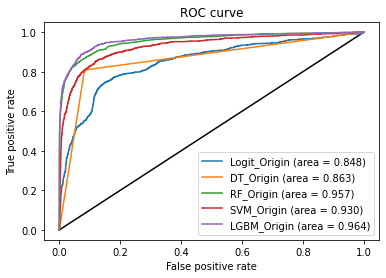

In [ ]:
# ROC 커브 시각화 
# F_positive_rate, T_positive_rate 구하기
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, logit_proba)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_proba)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_proba)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_proba)
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, lgb_proba)

#roc_auc
auc_logit = metrics.auc(fpr_logit, tpr_logit)
auc_dt = metrics.auc(fpr_dt, tpr_dt)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
auc_svm = metrics.auc(fpr_svm, tpr_svm)
auc_lgb = metrics.auc(fpr_lgb, tpr_lgb)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_logit, tpr_logit, label='Logit_Origin (area = {:.3f})'.format(auc_logit))
plt.plot(fpr_dt, tpr_dt, label='DT_Origin (area = {:.3f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, label='RF_Origin (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_svm, tpr_svm, label='SVM_Origin (area = {:.3f})'.format(auc_svm))
plt.plot(fpr_lgb, tpr_lgb, label='LGBM_Origin (area = {:.3f})'.format(auc_lgb))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## 2) KS Score
- Kolmogorov-Smirnov 통계량 계산 
- 액티브 기업 그룹과 휴폐업 기업 그룹의 분포 차이 계산 

In [ ]:
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

In [ ]:
#Logistic Regression 
prediction_LR = LR.predict(x_test_norm)

print('Logistic Regression 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_LR)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_LR)[y_test.reset_index(drop=True)==1].values.flatten())

Logistic Regression 모델 KS Score :


KstestResult(statistic=0.590968613902912, pvalue=2.1094237467877974e-15)

In [ ]:
#Decision Tree  
prediction_DT = tree.predict(x_test_norm)

print('Decision Tree 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_DT)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_DT)[y_test.reset_index(drop=True)==1].values.flatten())

Decision Tree 모델 KS Score :


KstestResult(statistic=0.7189243593727087, pvalue=3.3597569171206487e-12)

In [ ]:
#Random Forest 
prediction_RF = RF.predict(x_test_norm)

print('Random Forest 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==1].values.flatten())

Random Forest 모델 KS Score :


KstestResult(statistic=0.7660011977312836, pvalue=6.068812119508493e-12)

In [ ]:
#SVM
prediction_SVM = svm_clf.predict(x_test_norm)

print('SVM 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_SVM)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_SVM)[y_test.reset_index(drop=True)==1].values.flatten())

SVM 모델 KS Score :


KstestResult(statistic=0.7289345934122728, pvalue=6.196487767340386e-12)

In [ ]:
#LGBM
prediction_LGBM = lgb_model.predict(x_test_norm)

print('LGBM 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_LGBM)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_LGBM)[y_test.reset_index(drop=True)==1].values.flatten())

LGBM 모델 KS Score :


KstestResult(statistic=0.8158554805948048, pvalue=6.338707336794869e-12)

## 나. 제안 모델 학습
- 기업정보 데이터 + 재무 데이터 + 비재무 데이터(ESG)

### 1) Train/Test  분리
- train : test = 8 : 2 비율로 분리
- train set을 이용하여 변수선정, 샘플링, 표준화 진행 
- test set을 이용하여 최종 성능 비교 

In [ ]:
from sklearn.model_selection import train_test_split 

# string 변수 삭제
df_esg_final.drop([ 'MN_BIZ_CONT','결산년월','IND_CD1' ,'Industy_name'], axis=1, inplace=True)
# BIZ_NO를 인덱스로 설정 
df_esg_final = df_esg_final.set_index('BIZ_NO')
# train/test split 
X = df_esg_final.iloc[:, 1:]
y = df_esg_final['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1) 

### 2) Oversampling (SMOTE)
- Synthetic Minority Over-Sampling Technique 사용 
- 휴폐업 기업의 데이터가 상대적으로 부족하므로 증가시킴 



In [ ]:
#SMOTE 알고리즘을 이용한 오버샘플링 
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

print(y_train.value_counts()) #클래스 불균형 확인 

smote = SMOTE(sampling_strategy = 'minority') #minor class만 증가시키기 
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

print(y_train_over.value_counts()) #오버샘플링 결과 확인 

x_train = x_train_over
y_train = y_train_over

0    27541
1     7459
Name: target, dtype: int64
0    27541
1    27541
Name: target, dtype: int64


### 3) 변수 표준화 (Standardization)
- Standard Scaler를 이용하여 모든 변수 표준화 진행 
- 평균=0, 분산 =1 인 분포로 변환 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

x_train_norm = pd.DataFrame(scaler.fit_transform(x_train_over), columns = x_train.columns)
x_test_norm = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns )

# 제안 모델 학습
- 기업 정보 데이터 + 재무 데이터 + 비재무(ESG) 데이터 

### Logistic Regression 모델

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression


In [ ]:
#로지스틱 회귀 모델 학습 
LR = LogisticRegression()

LR.fit(x_train_norm, y_train_over) 
y_test_pred = LR.predict(x_test_norm) 
logit_proba = LR.predict_proba(x_test_norm)[:, 1] 

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6886
           1       0.56      0.80      0.66      1865

    accuracy                           0.82      8751
   macro avg       0.75      0.81      0.77      8751
weighted avg       0.86      0.82      0.83      8751



### Decision Tree 모델

In [ ]:
#의사결정나무 모델 학습
from sklearn import tree
tree = tree.DecisionTreeClassifier()

tree.fit(x_train_norm, y_train_over)
y_test_pred = tree.predict(x_test_norm)
dt_proba = tree.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6886
           1       0.79      0.85      0.82      1865

    accuracy                           0.92      8751
   macro avg       0.87      0.89      0.88      8751
weighted avg       0.92      0.92      0.92      8751



### Random Forest 모델

In [ ]:
#랜덤 포레스트 모델 학습
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()

#테스트셋 평가 
RF.fit(x_train_norm,y_train_over)
y_test_pred = RF.predict(x_test_norm)
rf_proba = RF.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6886
           1       0.92      0.86      0.89      1865

    accuracy                           0.95      8751
   macro avg       0.94      0.92      0.93      8751
weighted avg       0.95      0.95      0.95      8751



### Support Vector Machine 모델



In [ ]:
#SVM 모델 학습 
import sklearn.svm as svm
svm_clf =svm.SVC(probability=True, kernel = 'rbf')
svm_clf.fit(x_train_norm,y_train_over)

y_test_pred = svm_clf.predict(x_test_norm)
svm_proba = svm_clf.predict_proba(x_test_norm)[:, 1] 
# y_test_pred = grid.predict(x_test_norm)

print(classification_report(y_test, y_test_pred))
#confusion_matrix = confusion_matrix(y_test, y_test_pred)
#print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      6886
           1       0.68      0.85      0.75      1865

    accuracy                           0.88      8751
   macro avg       0.82      0.87      0.84      8751
weighted avg       0.90      0.88      0.89      8751



### LGBM 모델 

In [ ]:
#LGBM 모델 학습 
import lightgbm as lgb
from numpy import argmax 
from lightgbm import LGBMClassifier

final_params = {}

lgb_train = lgb.Dataset(x_train_norm, y_train_over)
num_round = 100
lgb_model = lgb.train(final_params,lgb_train, num_round)

#예측
y_pred_val = lgb_model.predict(x_test_norm)
lgb_proba = lgb_model.predict(x_test_norm)

print(y_pred_val) 

#cutoff 조정 
y_test_pred = pd.Series(y_pred_val).apply(lambda x: 1 if x>=0.5 else 0) 
print(classification_report(y_test, y_test_pred))

[ 0.03261392 -0.03033102  0.70298447 ...  0.99611516  0.72901422
  0.99794141]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6886
           1       0.83      0.88      0.86      1865

    accuracy                           0.94      8751
   macro avg       0.90      0.92      0.91      8751
weighted avg       0.94      0.94      0.94      8751



# 제안 모델 성능 평가
- 기업정보 + 재무 데이터 + 비재무 데이터 (ESG)

## 1) ROC Curve
- Receiver Operatin Characteristic 
- 모든 cutoff 값에 대해서 각 모델의 성능을 확인하고 비교 

In [ ]:
## ROC 곡선 
from sklearn.metrics import roc_curve
from sklearn import metrics
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

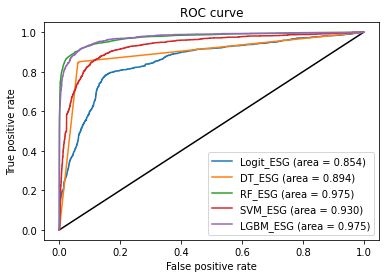

In [ ]:
# ROC 커브 시각화 
# F_positive_rate, T_positive_rate 구하기
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, logit_proba)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_proba)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_proba)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_proba)
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, lgb_proba)

#roc_auc
auc_logit = metrics.auc(fpr_logit, tpr_logit)
auc_dt = metrics.auc(fpr_dt, tpr_dt)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
auc_svm = metrics.auc(fpr_svm, tpr_svm)
auc_lgb = metrics.auc(fpr_lgb, tpr_lgb)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_logit, tpr_logit, label='Logit_ESG (area = {:.3f})'.format(auc_logit))
plt.plot(fpr_dt, tpr_dt, label='DT_ESG (area = {:.3f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, label='RF_ESG (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_svm, tpr_svm, label='SVM_ESG (area = {:.3f})'.format(auc_svm))
plt.plot(fpr_lgb, tpr_lgb, label='LGBM_ESG (area = {:.3f})'.format(auc_lgb))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## 2) KS Score
- Kolmogorov-Smirnov 통계량 계산 
- 액티브 기업 그룹과 휴폐업 기업 그룹의 분포 차이 계산 

In [ ]:
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

In [ ]:
#Logistic Regression 
prediction_LR = LR.predict(x_test_norm)

print('Logistic Regression 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_LR)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_LR)[y_test.reset_index(drop=True)==1].values.flatten())

Logistic Regression 모델 KS Score :


KstestResult(statistic=0.6272080196910388, pvalue=0.7680665904848861)

In [ ]:
#Decision Tree  
prediction_DT = tree.predict(x_test_norm)

print('Decision Tree 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_DT)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_DT)[y_test.reset_index(drop=True)==1].values.flatten())

Decision Tree 모델 KS Score :


KstestResult(statistic=0.7843931698071777, pvalue=0.9823511762220775)

In [ ]:
#Random Forest 
prediction_RF = RF.predict(x_test_norm)

print('Random Forest 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_RF)[y_test.reset_index(drop=True)==1].values.flatten())

Random Forest 모델 KS Score :


KstestResult(statistic=0.8385049044609297, pvalue=0.9830627604417309)

In [ ]:
#SVM
prediction_SVM = svm_clf.predict(x_test_norm)

print('SVM 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_SVM)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_SVM)[y_test.reset_index(drop=True)==1].values.flatten())

SVM 모델 KS Score :


KstestResult(statistic=0.7408599178190353, pvalue=0.9817149805111698)

In [ ]:
#LGBM
prediction_LGBM = lgb_model.predict(x_test_norm)

print('LGBM 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_LGBM)[y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_LGBM)[y_test.reset_index(drop=True)==1].values.flatten())

LGBM 모델 KS Score :


KstestResult(statistic=0.8461333131917034, pvalue=0.9823558805284862)